Last updated: February 10, 2025

This project was originally done in April 2022 and was originally a group project by the three of us:
- [Iris Lew](https://www.linkedin.com/in/iris-lew/)
- [Rebecca Sun](https://www.linkedin.com/in/rebeccasun3/)
- [Ben Meier](https://www.linkedin.com/in/meierbenjamin/)

We were tasked to do an exploratory data analysis (EDA). While the overall structure and some of the analysis is the same, I've redone the writeup, code, and updated the analysis in October-December 2022. In June 2024, I added in the regression discontinuity design for additional analysis. In February 2025, I added in the analysis for the unincorporated areas only.

This notebook is split into three parts:

1.   EDA
2.   Analysis on the Full Dataset
3.   Analysis on the Unincorporated Areas Only

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iris-lew/projects/blob/main/project_001_LATrafficCollisions/LA_Traffic_Collisions_3_Analysis_Unincorporated.ipynb)


# Setup

I set up the necessary libraries to import the data, do the analysis, and create plots.

In [1]:
### delete when done
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [2]:
!pip install rdrobust

In [3]:
# Import modules
from copy import deepcopy
from matplotlib import ticker

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

import folium
from IPython.display import HTML
from folium.plugins import HeatMap

pd.set_option('display.max_columns', None)

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from rdrobust import rdrobust, rdbwselect, rdplot

import geopandas as gpd
from shapely.geometry import Point

In [4]:
def grapher(df, var):
    sns.set_theme(style="whitegrid")
    sns.set_style("ticks")

    df[["All","Victims"]].plot(kind="bar",edgecolor="black", figsize=(18,4))
    plt.ylabel("Number of Collisions")
    plt.xlabel(var)
    plt.xticks(rotation=0)
    plt.title("Number of Collisions by "+var)
    plt.legend(bbox_to_anchor=(1,1,0,0))
    plt.tight_layout()
    plt.grid(False)

    figure, ax = plt.subplots(1,3,sharey=True,figsize=(18,4), facecolor="white")

    df[["0-10","11-20","21-30",
        "31-40","41-50","51-60","61-70","71-80","81-90","91-98"]].plot(ax=ax[0],
                                                                       kind="bar",
                                                                       edgecolor="black",
                                                                       stacked=True,
                                                                      color = ["red",
                                                                               "orange",
                                                                               "yellow",
                                                                               "green",
                                                                               "blue",
                                                                              "indigo",
                                                                               "olive",
                                                                               "brown",
                                                                              "violet",
                                                                              "gray"])

    ax[0].legend(bbox_to_anchor=(0,0,.4,-.25))
    ax[0].set_title("Number of Collisions by Victim Age")
    ax[0].set_ylabel("Number of Collisions")
    ax[0].grid(False)

    df[["Male",
        "Female",
        "Other/Unknown"]].plot(ax=ax[1],
                               kind="bar",
                               edgecolor="black",
                               stacked=True,
                              color = ["cyan","purple","gray"])

    ax[1].legend(bbox_to_anchor=(0,0,.7,-.3))
    ax[1].set_title("Number of Collisions by Victim Sex")
    ax[1].grid(False)

    df[['Hispanic/Latin/Mexican', 'White','Black', 'Asian',
        'Native Hawaiian/Pacific Islander','Other','Unknown']].plot(ax=ax[2],
                                             kind="bar",
                                             edgecolor="black",
                                             stacked=True,
                                             color = ["azure","yellowgreen","olive","coral",
                                                     "chocolate","plum","gray"])

    ax[2].legend(bbox_to_anchor=(0,0,1,-.3))
    ax[2].set_title("Number of Collisions by Victim Descent")
    ax[2].grid(False)

In [5]:
dfin = pd.read_pickle('LA_Traffic_Collisions_dfin_2.pkl')
print(dfin.shape)
dfin.head()

(569291, 52)


,dr_number,date_reported,date_occurred,time_occurred,area_id,area_name,reporting_district,mo_codes,victim_age,victim_sex,victim_descent,premise_code,premise_description,address,cross_street,location,dttm_occurred,date_reported_dt,victim,reported_occurred_diff,reported_occurred_diff_int,rd_fid,rd_repdist,rd_prec,rd_aprec,rd_bureau,rd_basiccar,rd_area,rd_perimeter,rd_shape_length,rd_shape_area,address_clean,cross_street_clean,location_clean,latitude,longitude,victim_sex_clean,victim_descent_clean,all,age_range,hour,time_of_day,year,month,day,date_temp,season,day_of_week,intersection_temp,intersection_clean,pre_post_vision_zero,postcovid
0,190319651,08/24/2019,08/24/2019,04:50,3,Southwest,356,3036 3004 3026 3101 4003,22.0,M,H,101.0,STREET,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",2019-08-24 04:50:00,2019-08-24,True,0:00:00,0,808.0,356.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.018806e+06,10591.266020,0.032011,0.000064,JEFFERSON BL,NORMANDIE AV,"(34.0255, -118.3002)",34.0255,-118.3002,Male,Hispanic/Latin/Mexican,True,21-30,4,Morning,2019,8,24,824,Summer,Saturday,"JEFFERSON BL, NORMANDIE AV","JEFFERSON BL, NORMANDIE AV","1461 days, 0:00:00","-200 days, 0:00:00"
1,190319680,08/30/2019,08/30/2019,23:20,3,Southwest,355,3037 3006 3028 3030 3039 3101 4003,30.0,F,H,101.0,STREET,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",2019-08-30 23:20:00,2019-08-30,True,0:00:00,0,807.0,355.0,3.0,SOUTHWEST,SOUTH BUREAU,3A55,7.072090e+06,10823.145761,0.032805,0.000064,JEFFERSON BL,W WESTERN,"(34.0256, -118.3089)",34.0256,-118.3089,Female,Hispanic/Latin/Mexican,True,21-30,23,Night,2019,8,30,830,Summer,Friday,"JEFFERSON BL, W WESTERN","JEFFERSON BL, W WESTERN","1467 days, 0:00:00","-194 days, 0:00:00"
2,190413769,08/25/2019,08/25/2019,05:45,4,Hollenbeck,422,3101 3401 3701 3006 3030,NaN,M,X,101.0,STREET,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",2019-08-25 05:45:00,2019-08-25,True,0:00:00,0,566.0,422.0,4.0,HOLLENBECK,CENTRAL BUREAU,4A15,7.004384e+06,10750.107952,0.033034,0.000064,N BROADWAY,W EASTLAKE AV,"(34.0738, -118.2078)",34.0738,-118.2078,Male,Unknown,True,NaN,5,Morning,2019,8,25,825,Summer,Sunday,"N BROADWAY, W EASTLAKE AV","N BROADWAY, W EASTLAKE AV","1462 days, 0:00:00","-199 days, 0:00:00"
3,190127578,11/20/2019,11/20/2019,03:50,1,Central,128,0605 3101 3401 3701 3011 3034,21.0,M,H,101.0,STREET,1ST,CENTRAL,"(34.0492, -118.2391)",2019-11-20 03:50:00,2019-11-20,True,0:00:00,0,1070.0,128.0,1.0,CENTRAL,CENTRAL BUREAU,1A29,1.534550e+06,6220.695545,0.018408,0.000014,1ST,CENTRAL,"(34.0492, -118.2391)",34.0492,-118.2391,Male,Hispanic/Latin/Mexican,True,21-30,3,Night,2019,11,20,1120,Autumn,Wednesday,"1ST, CENTRAL","1ST, CENTRAL","1549 days, 0:00:00","-112 days, 0:00:00"
4,190319695,08/30/2019,08/30/2019,21:00,3,Southwest,374,0605 4025 3037 3004 3025 3101,49.0,M,B,101.0,STREET,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",2019-08-30 21:00:00,2019-08-30,True,0:00:00,0,829.0,374.0,3.0,SOUTHWEST,SOUTH BUREAU,3A73,8.625945e+06,12173.689427,0.036845,0.000078,MARTIN LUTHER KING JR,ARLINGTON AV,"(34.0108, -118.3182)",34.0108,-118.3182,Male,Black,True,41-50,21,Evening,2019,8,30,830,Summer,Friday,"MARTIN LUTHER KING JR, ARLINGTON AV","MARTIN LUTHER KING JR, ARLINGTON AV","1467 days, 0:00:00","-194 days, 0:00:00"


In [6]:
mo_fin = pd.read_pickle('LA_Traffic_Collisions_mo_fin_2.pkl')
print(mo_fin.shape)
mo_fin.head()

(3160710, 7)


,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic,vs
0,190319651,mo_code_0,3036,T/C - At Intersection - Yes,3036,True,False
1,190319680,mo_code_0,3037,T/C - At Intersection - No,3037,True,False
2,190413769,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101,True,False
3,190127578,mo_code_0,0605,Traffic Accident/Traffic related incident,0605,True,False
4,190319695,mo_code_0,0605,Traffic Accident/Traffic related incident,0605,True,False


As I want to examine the effects of Vision Zero, I created two additional data frames off of these initital data frames: pre-Vision Zero (before Aug 24, 2015) and post-Vision Zero (the day of and after Aug 24, 2015).

In [7]:
dfin_p2015 = dfin[dfin.dttm_occurred.dt.date<datetime.date(2015,8,24)]
dfin_2015p = dfin[dfin.dttm_occurred.dt.date>=datetime.date(2015,8,24)]

# Analysis Unincorporated Areas

If Vision Zero is only going to be on unincorporated roadways, I need to filter the data to only be on collisions in unincorporated areas. I found a [dataset](https://egis-lacounty.hub.arcgis.com/datasets/8ea349021cf544adb9bb079d3631df77_0/explore?location=33.797441%2C-118.298821%2C6.84) that I could use to determine which collisions happened in the incorporated city vs. the unincorporated areas. The version of the dataset I used was downloaded on January 22, 2025.

/usr/local/lib/python3.11/dist-packages/pyogrio/raw.py:198: RuntimeWarning: admin_dist_SDE_DIST_DRP_CITY_COMM_BDY.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.


<Axes: >

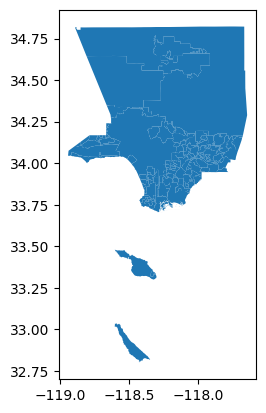

In [8]:
LA = gpd.read_file(r'admin_dist_SDE_DIST_DRP_CITY_COMM_BDY.shp')
LA = LA.to_crs(epsg='4326')
LA.plot()

<Axes: >

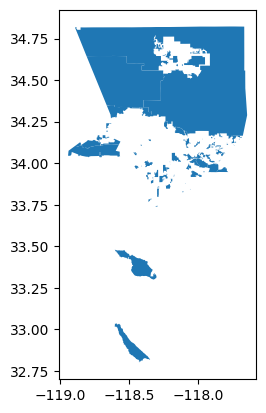

In [9]:
unincorporated = LA[LA['JURISDICTI']=="UNINCORPORATED AREA"]
unincorporated.plot()

This is a plot of the collisions with the incorporated and unincorporated areas' boundaries of LA. This is to ensure that the geographical coordinates in the shape file are aligning with the map and are able to capture the traffic collision data.

In [10]:
lat = dfin["latitude"][np.logical_not(np.isnan(dfin["latitude"]))]
lon = dfin["longitude"][np.logical_not(np.isnan(dfin["longitude"]))]

top5 = dfin[["intersection_clean","latitude","longitude"]].value_counts().reset_index(name="counts").head()

map = folium.Map(location=[dfin["latitude"].mean(),dfin["longitude"].mean()],
                 zoom_start=8.5,
                 control_scale=True)
HeatMap(list(zip(lat, lon))).add_to(map)

for row in top5.itertuples():
    folium.Marker([row.latitude, row.longitude],
                 popup=row.intersection_clean,
                 icon=folium.Icon(color="red")).add_to(map)

In [11]:
map1 = deepcopy(map)
folium.GeoJson(LA).add_to(map1)
map1

Output hidden; open in https://colab.research.google.com to view.

This is a plot of the collisions with only the boundaries of the unincorporated areas overlaid on top of it.

In [12]:
victim_dttm = dfin[["dr_number", "victim","dttm_occurred"]]
mo_fin_vict = pd.merge(mo_fin,
                       victim_dttm,
                       on = "dr_number",
                       how = "left")
mo_fin_vict.loc[:,"injury"] = mo_fin_vict["code_def"].str.contains("Injury|injury", na=False)

injuries = mo_fin_vict[mo_fin_vict["injury"]]
injuries["code_def"] = injuries["code_def"].str[10:]

sev_fat = injuries[injuries["mo_code_clean"].isin(["3024","3027"])] ### duplicated dr_numbers

<ipython-input-12-ba665f9e4739>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
severe_fat_dr_numbers = sev_fat.dr_number.unique()
severe_fat_dr_numbers = pd.DataFrame(severe_fat_dr_numbers, columns=["dr_number"])

df_severe_fatal = dfin.merge(severe_fat_dr_numbers, on='dr_number', how='inner')

lat_sev_fat = df_severe_fatal["latitude"][np.logical_not(np.isnan(df_severe_fatal["latitude"]))]
lon_sev_fat = df_severe_fatal["longitude"][np.logical_not(np.isnan(df_severe_fatal["longitude"]))]

map_severe_fatal = folium.Map(location=[df_severe_fatal["latitude"].mean(),df_severe_fatal["longitude"].mean()],
                 zoom_start=10,
                 control_scale=True)
HeatMap(list(zip(lat_sev_fat, lon_sev_fat))).add_to(map_severe_fatal)

map_severe_fatal

In [14]:
map1_severe_fatal = deepcopy(map_severe_fatal)
folium.GeoJson(LA).add_to(map1_severe_fatal)
map1_severe_fatal

Output hidden; open in https://colab.research.google.com to view.

The collisions with severe or fatal injuries do happen in LA and are captured in the map.

In [15]:
map2 = deepcopy(map)
folium.GeoJson(unincorporated).add_to(map2)
map2

Output hidden; open in https://colab.research.google.com to view.

In [16]:
map2_severe_fatal = deepcopy(map_severe_fatal)
folium.GeoJson(unincorporated).add_to(map2_severe_fatal)
map2_severe_fatal

Output hidden; open in https://colab.research.google.com to view.

Notice how the majority of the collisions, including the collisions with severe or fatal injuries, happen more often than not in the *unincorporated* areas.

This means that if Vision Zero is supposed to be reducing the number of severe or fatal collisions, it's likely going to be ineffective because there are fewer collisions in general (it's hard to reduce 1 to 0). If Vision Zero is an effective program, the best places to implement them are areas of high collisions because that's where it's needed most.

I still proceeded with repeating the analysis, but this time filtering for only the collisions that are in the unincorporated areas.

In [17]:
withinQlist_unincorporated = []
for lon,lat in zip(dfin.longitude, dfin.latitude):
    pt = Point(lon, lat)
    within = False
    i = 0
    while within is False and i<=(len(unincorporated)-1):
      within = pt.within(unincorporated['geometry'].values[i])
      i+=1
    withinQlist_unincorporated.append(within)
print(withinQlist_unincorporated.count(True))
print(withinQlist_unincorporated.count(False))

dfin['unincorporated'] = withinQlist_unincorporated
dfin['unincorporated'].value_counts(dropna=False)

1606
567685


,count
unincorporated,
False,567685
True,1606


In [18]:
dfin_ui = dfin[dfin['unincorporated']]

dfin_ui_p2015 = dfin_ui[dfin_ui.dttm_occurred.dt.date<datetime.date(2015,8,24)]
dfin_ui_2015p = dfin_ui[dfin_ui.dttm_occurred.dt.date>=datetime.date(2015,8,24)]

### Dates and Time

<ipython-input-19-847932aab63e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


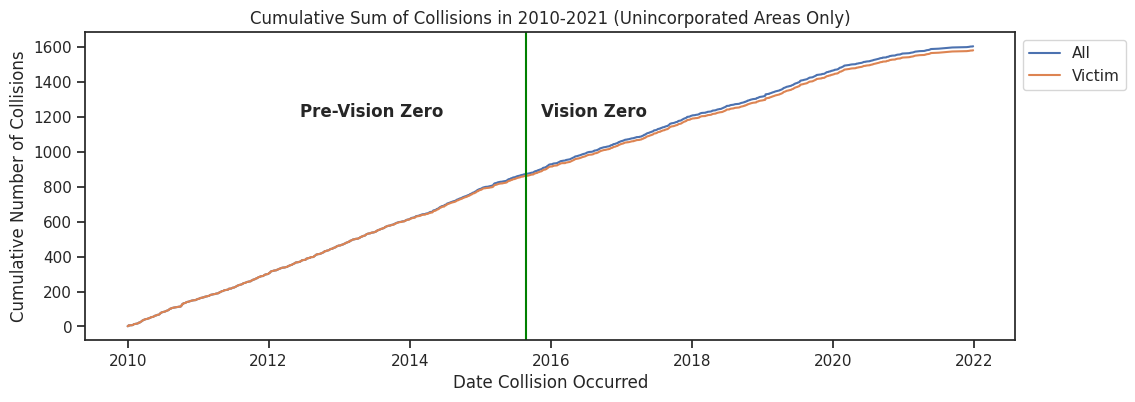

In [19]:
dfin_ui["all"] = True

c_all_unincorporated = pd.DataFrame(dfin_ui.groupby(dfin_ui["dttm_occurred"].dt.date)["all"].sum())
c_all_unincorporated = c_all_unincorporated.cumsum().rename(columns={"all":"All"})
c_all_unincorporated

c_victim_unincorporated = pd.DataFrame(dfin_ui[["victim"]].groupby(dfin_ui["dttm_occurred"].dt.date)["victim"].sum())
c_victim_unincorporated = c_victim_unincorporated.cumsum().rename(columns={"victim":"Victim"})
c_victim_unincorporated

c_ui = c_all_unincorporated.join(c_victim_unincorporated, how='left', sort=True)
c_ui

sns.set_theme(style="whitegrid")
sns.set_style("ticks")

fig = plt.figure(figsize=(12,4))
plt.plot(c_ui.All, label="All")
plt.plot(c_ui.Victim, label="Victim")
plt.title("Cumulative Sum of Collisions in 2010-2021 (Unincorporated Areas Only)")
plt.xlabel("Date Collision Occurred")
plt.ylabel("Cumulative Number of Collisions")

plt.axvline(pd.to_datetime("2015-08-24"), color="green")
font = {'weight': 'bold',
        'size': 12}
plt.text(15500,1200, "Pre-Vision Zero", fontdict=font)
plt.text(16750,1200, "Vision Zero", fontdict=font)

plt.legend(bbox_to_anchor=(1,1,0,0))
plt.grid(False)

The cumulative sum of the collisions doesn't change much in shape, but the numbers are far lower.

<ipython-input-20-df16d672d735>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


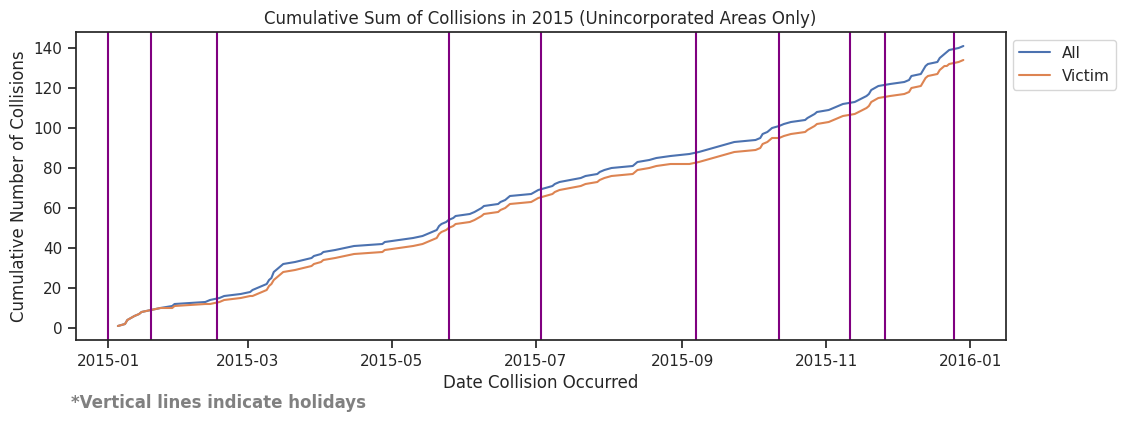

In [20]:
cal = calendar()
cal.holidays()
holidays_ui = cal.holidays(start=dfin_ui.dttm_occurred.dt.date.min(), end=dfin_ui.dttm_occurred.dt.date.max())
holidays_dt_ui = pd.to_datetime(holidays_ui)

holidays_dt_2015_ui = pd.to_datetime(holidays_ui)[50:60]
holidays_dt_2015_ui

c_all_2015_ui = pd.DataFrame(dfin_ui[dfin_ui["dttm_occurred"].dt.year==2015].\
                          groupby(dfin_ui["dttm_occurred"].dt.date)["all"].sum())
c_all_2015_ui = c_all_2015_ui.cumsum().rename(columns={"all":"All"})
c_all_2015_ui

c_victim_2015_ui = pd.DataFrame(dfin_ui[(dfin_ui.victim) & (dfin_ui.dttm_occurred.dt.year==2015)].\
                             groupby(dfin_ui["dttm_occurred"].dt.date)["victim"].sum())
c_victim_2015_ui = c_victim_2015_ui.cumsum().rename(columns={"victim":"Victim"})
c_victim_2015_ui

c_2015_ui = c_all_2015_ui.join(c_victim_2015_ui, how='left', sort=True)
c_2015_ui.fillna(method='ffill', inplace=True)
c_2015_ui

sns.set_theme(style="whitegrid")
sns.set_style("ticks")

fig2 = plt.figure(figsize=(12,4))
plt.plot(c_2015_ui.All, label="All")
plt.plot(c_2015_ui.Victim, label="Victim")
plt.title("Cumulative Sum of Collisions in 2015 (Unincorporated Areas Only)")
plt.xlabel("Date Collision Occurred")
plt.ylabel("Cumulative Number of Collisions")
[plt.axvline(pd.to_datetime(i), color="purple") for i in holidays_dt_2015_ui]
plt.legend(bbox_to_anchor=(1,1,0,0))
plt.grid(False)

font = {'weight': 'bold',
        "color": "gray",
        'size': 12}
plt.text(16420,-40, "*Vertical lines indicate holidays", fontdict=font)
plt.show()

There is still a steady increase in collisions, but the breaks in the victim line indicates that there were no collisions that had a victim on those dates.

In [21]:
bins = range(0,101,10)
names = ["0-10","11-20","21-30","31-40","41-50","51-60","61-70","71-80","81-90","91-98"]
dfin_ui["age_range"] = pd.cut(dfin_ui["victim_age"],bins,labels=names)


dfin_ui["hour"] = dfin_ui["dttm_occurred"].dt.hour

dfin_ui['time_of_day'] = pd.cut(dfin_ui["hour"],[0,4,10,16,22,24],
                             labels=['Night','Morning','Noon','Evening','Night '],
                             right=False).str.strip()

<ipython-input-21-081daec2e6d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-081daec2e6d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-21-081daec2e6d2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
dfin_ui["time_of_day"].value_counts()

,count
time_of_day,
Evening,591
Noon,481
Morning,293
Night,241


Similar to the full dataset, most of the collisions are occurring in the evneing and noon, with a drop off to the morning and the night.

In [23]:
dfin_ui["year"] = dfin_ui["dttm_occurred"].dt.year

year_a_ui = pd.DataFrame(dfin_ui["year"].value_counts()).rename(columns = {"count":"All"})
year_a_ui


year_v_ui = pd.DataFrame(dfin_ui[dfin_ui["victim"]]["year"].value_counts()).rename(columns = {"count":"Victims"})
year_v_ui

year_va_ui = dfin_ui.groupby("year")["age_range"]\
                     .value_counts().unstack()

year_vs_ui = dfin_ui.groupby("year")["victim_sex_clean"]\
                     .value_counts().unstack()

year_vd_ui = dfin_ui.groupby("year")["victim_descent_clean"]\
                     .value_counts().unstack()

year_ui = year_a_ui.join([year_v_ui, year_va_ui, year_vs_ui, year_vd_ui])
year_ui = year_ui.reindex(range(2010,2022))
year_ui

<ipython-input-23-baa0df09f083>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
year,,,,,,,,,,,,,,,,,,,,,,,
2010,156,156,0,6,29,40,20,16,10,5,4,0,62.0,94.0,NaN,NaN,6.0,34.0,43.0,NaN,22.0,1.0,50.0
2011,145,145,0,4,39,24,26,25,7,1,0,3,64.0,80.0,1.0,NaN,8.0,27.0,46.0,NaN,18.0,3.0,43.0
2012,162,162,0,4,39,24,27,20,5,5,1,2,56.0,98.0,8.0,NaN,7.0,29.0,47.0,1.0,14.0,10.0,54.0
2013,153,151,0,2,37,24,23,18,11,3,3,3,54.0,95.0,2.0,NaN,5.0,30.0,39.0,2.0,25.0,7.0,43.0
2014,172,168,0,2,43,28,24,31,9,7,0,2,66.0,97.0,5.0,NaN,6.0,43.0,44.0,NaN,24.0,8.0,43.0
2015,141,134,0,1,31,23,24,15,18,3,1,0,60.0,70.0,4.0,NaN,2.0,31.0,55.0,NaN,8.0,8.0,30.0
2016,133,130,0,2,31,29,22,19,10,2,0,0,53.0,75.0,2.0,2.0,4.0,34.0,43.0,NaN,12.0,4.0,30.0
2017,146,144,0,1,26,39,18,23,12,4,1,3,54.0,85.0,4.0,NaN,5.0,33.0,45.0,NaN,22.0,7.0,30.0
2018,109,105,0,0,35,20,17,11,7,2,1,3,51.0,49.0,3.0,NaN,5.0,27.0,32.0,NaN,10.0,4.0,24.0


In [24]:
dfin_ui["month"] = dfin_ui["dttm_occurred"].dt.month

month_a_ui = pd.DataFrame(dfin_ui["month"].value_counts()).rename(columns = {"count":"All"})

month_v_ui = pd.DataFrame(dfin_ui[dfin_ui["victim"]]["month"].value_counts()).rename(columns = {"count":"Victims"})

month_va_ui = dfin_ui.groupby("month")["age_range"]\
                     .value_counts().unstack()

month_vs_ui = dfin_ui.groupby("month")["victim_sex_clean"]\
                     .value_counts().unstack()#\

month_vd_ui = dfin_ui.groupby("month")["victim_descent_clean"]\
                     .value_counts().unstack()

month_ui = month_a_ui.join([month_v_ui,month_va_ui, month_vs_ui, month_vd_ui])
month_ui = month_ui.reindex(range(1,13))
month_ui.rename(index = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}, inplace=True)

month_ui

<ipython-input-24-b069b9e5c9ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
month,,,,,,,,,,,,,,,,,,,,,,,
January,128,125,0,3,22,28,23,18,5,1,2,2,53.0,67.0,4.0,NaN,7.0,33.0,31.0,NaN,21.0,4.0,28.0
February,129,126,0,6,23,33,20,15,5,6,0,2,46.0,73.0,3.0,NaN,8.0,33.0,35.0,NaN,19.0,7.0,18.0
March,114,110,0,5,28,20,22,11,8,2,2,1,38.0,68.0,2.0,NaN,6.0,25.0,29.0,NaN,12.0,5.0,30.0
April,128,126,0,5,35,19,14,20,9,4,0,4,47.0,72.0,6.0,1.0,4.0,36.0,33.0,NaN,14.0,9.0,28.0
May,145,144,0,6,33,29,23,16,11,3,2,0,56.0,83.0,5.0,NaN,3.0,35.0,44.0,NaN,15.0,9.0,38.0
June,144,142,0,6,37,20,19,23,15,6,1,1,60.0,81.0,NaN,NaN,3.0,32.0,40.0,1.0,16.0,2.0,47.0
July,139,139,0,3,38,29,19,14,11,4,1,4,58.0,78.0,3.0,NaN,4.0,28.0,38.0,1.0,16.0,9.0,43.0
August,134,133,0,4,32,27,24,15,11,2,0,1,50.0,79.0,3.0,1.0,6.0,22.0,46.0,NaN,16.0,5.0,36.0
September,112,110,0,4,26,23,18,12,4,5,1,1,46.0,58.0,6.0,NaN,2.0,16.0,37.0,NaN,14.0,7.0,34.0


In [25]:
dfin_ui["day"] = dfin_ui["dttm_occurred"].dt.day

day_a_ui = pd.DataFrame(dfin_ui["day"].value_counts()).rename(columns = {"count":"All"})


day_v_ui = pd.DataFrame(dfin_ui[dfin_ui["victim"]]["day"].value_counts()).rename(columns = {"count":"Victims"})

day_va_ui = dfin_ui.groupby("day")["age_range"]\
                     .value_counts().unstack()

day_vs_ui = dfin_ui.groupby("day")["victim_sex_clean"]\
                     .value_counts().unstack()#\

day_vd_ui = dfin_ui.groupby("day")["victim_descent_clean"]\
                     .value_counts().unstack()

day_ui = day_a_ui.join([day_v_ui,day_va_ui, day_vs_ui, day_vd_ui])
day_ui = day_ui.reindex(range(1,32))
day_ui

<ipython-input-25-8611465300ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
day,,,,,,,,,,,,,,,,,,,,,,,
1,51,51,0,3,13,11,5,7,7,0,1,0,20.0,28.0,3.0,NaN,2.0,10.0,18.0,NaN,5.0,3.0,13.0
2,61,61,0,0,15,16,11,4,6,3,2,0,25.0,35.0,1.0,NaN,1.0,16.0,19.0,NaN,4.0,1.0,20.0
3,53,51,0,2,13,9,10,3,1,3,0,1,14.0,35.0,1.0,NaN,1.0,10.0,18.0,NaN,9.0,1.0,11.0
4,52,49,0,3,10,13,4,7,2,2,1,0,18.0,29.0,2.0,NaN,2.0,11.0,14.0,NaN,7.0,3.0,12.0
5,49,49,0,2,10,9,6,8,5,3,0,1,23.0,24.0,1.0,NaN,1.0,11.0,14.0,1.0,5.0,2.0,14.0
6,49,48,0,2,11,14,7,4,4,3,0,1,22.0,26.0,NaN,NaN,1.0,14.0,11.0,NaN,5.0,1.0,16.0
7,48,47,0,2,13,11,7,6,1,1,0,0,17.0,28.0,1.0,NaN,NaN,13.0,14.0,NaN,6.0,2.0,11.0
8,57,57,0,2,12,11,7,7,6,0,1,0,28.0,26.0,3.0,NaN,2.0,13.0,21.0,NaN,9.0,3.0,9.0
9,66,66,0,1,17,11,14,10,1,2,1,1,17.0,48.0,NaN,NaN,2.0,19.0,22.0,NaN,8.0,1.0,13.0


In [26]:
dfin_ui["date_temp"] = dfin_ui.month*100 + dfin_ui.day
dfin_ui['season'] = (pd.cut(dfin_ui.date_temp,[0,321,621,922,1221,1300],
                       labels=['Winter','Spring','Summer','Autumn','Winter '])
                  .str.strip()
               )
dfin_ui[["season","month"]].value_counts().sort_index()

season_a_ui = pd.DataFrame(dfin_ui["season"].value_counts()).rename(columns = {"count":"All"})


season_v_ui = pd.DataFrame(dfin_ui[dfin_ui["victim"]]["season"].value_counts()).rename(columns = {"count":"Victims"})

season_va_ui = dfin_ui.groupby("season")["age_range"]\
                     .value_counts().unstack()

season_vs_ui = dfin_ui.groupby("season")["victim_sex_clean"]\
                     .value_counts().unstack()#\

season_vd_ui = dfin_ui.groupby("season")["victim_descent_clean"]\
                     .value_counts().unstack()

season_ui = season_a_ui.join([season_v_ui,season_va_ui, season_vs_ui, season_vd_ui])
season_ui = season_ui.reindex(["Spring","Summer","Autumn","Winter"])

season_ui

<ipython-input-26-ca342856cac5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-26-ca342856cac5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
season,,,,,,,,,,,,,,,,,,,,,,,
Spring,415,410,0,17,104,69,56,56,37,12,3,5,163,235,11,1.0,14.0,107.0,114.0,1.0,44.0,21.0,107.0
Summer,395,392,0,11,100,79,62,46,25,11,2,6,155,226,9,1.0,11.0,69.0,126.0,1.0,44.0,18.0,120.0
Autumn,412,409,0,13,92,85,61,59,33,11,3,1,166,226,15,NaN,16.0,93.0,141.0,1.0,43.0,18.0,94.0
Winter,384,372,0,14,73,82,64,51,18,9,4,7,139,214,12,NaN,17.0,92.0,101.0,1.0,56.0,18.0,77.0


In [27]:
dfin_ui["day_of_week"] = dfin_ui.dttm_occurred.dt.day_name()
dow_a_ui = pd.DataFrame(dfin_ui["day_of_week"].value_counts()).rename(columns = {"count":"All"})


dow_v_ui = pd.DataFrame(dfin_ui[dfin_ui["victim"]]["day_of_week"].value_counts()).rename(columns = {"count":"Victims"})

dow_va_ui = dfin_ui.groupby("day_of_week")["age_range"]\
                     .value_counts().unstack()

dow_vs_ui = dfin_ui.groupby("day_of_week")["victim_sex_clean"]\
                     .value_counts().unstack()#\

dow_vd_ui = dfin_ui.groupby("day_of_week")["victim_descent_clean"]\
                     .value_counts().unstack()


dow_ui = dow_a_ui.join([dow_v_ui,dow_va_ui, dow_vs_ui, dow_vd_ui])
dow_ui = dow_ui.reindex(["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"])

dow_ui

<ipython-input-27-0c8b31441424>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
day_of_week,,,,,,,,,,,,,,,,,,,,,,,
Sunday,193,191,0,7,50,34,29,16,19,7,0,5,77,107,7,NaN,4.0,40.0,67.0,1.0,30.0,9.0,40.0
Monday,225,219,0,4,50,40,37,27,20,11,3,2,91,122,5,1.0,11.0,44.0,58.0,NaN,25.0,9.0,69.0
Tuesday,236,229,0,6,51,53,35,33,18,3,1,2,96,125,6,NaN,6.0,43.0,66.0,2.0,29.0,12.0,68.0
Wednesday,220,217,0,10,44,46,38,32,9,6,0,2,84,124,7,NaN,6.0,55.0,62.0,NaN,28.0,11.0,53.0
Thursday,252,250,0,11,58,51,44,31,19,6,2,1,101,138,10,NaN,11.0,52.0,81.0,NaN,34.0,11.0,58.0
Friday,257,255,0,6,59,51,32,46,18,7,3,5,104,144,5,NaN,11.0,70.0,89.0,1.0,22.0,9.0,51.0
Saturday,223,222,0,11,57,40,28,27,10,3,3,2,70,141,7,1.0,9.0,57.0,59.0,NaN,19.0,14.0,59.0


In [28]:
tod_a_ui = pd.DataFrame(dfin_ui["time_of_day"].value_counts()).rename(columns = {"count":"All"})


tod_v_ui = pd.DataFrame(dfin_ui[dfin_ui["victim"]]["time_of_day"].value_counts()).rename(columns = {"count":"Victims"})

tod_va_ui = dfin_ui.groupby("time_of_day")["age_range"]\
                     .value_counts().unstack()

tod_vs_ui = dfin_ui.groupby("time_of_day")["victim_sex_clean"]\
                     .value_counts().unstack()

tod_vd_ui = dfin_ui.groupby("time_of_day")["victim_descent_clean"]\
                     .value_counts().unstack()

tod_ui = tod_a_ui.join([tod_v_ui,tod_va_ui, tod_vs_ui, tod_vd_ui])
tod_ui = tod_ui.reindex(["Morning","Noon","Evening","Night"])
tod_ui

,All,Victims,0-10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,81-90,91-98,Female,Male,Other/Unknown,American Indian/Alaskan Native,Asian,Black,Hispanic/Latin/Mexican,Native Hawaiian/Pacific Islander,Other,Unknown,White
time_of_day,,,,,,,,,,,,,,,,,,,,,,,
Morning,293,289,0,6,61,48,49,46,26,12,3,3,104,171,13,NaN,13.0,54.0,93.0,1.0,39.0,16.0,71.0
Noon,481,475,0,14,103,102,73,65,42,13,6,7,204,256,12,NaN,21.0,102.0,140.0,NaN,53.0,25.0,130.0
Evening,591,584,0,22,134,127,86,83,32,13,2,5,247,316,17,1.0,18.0,150.0,175.0,3.0,56.0,24.0,151.0
Night,241,235,0,13,71,38,35,18,13,5,1,4,68,158,5,1.0,6.0,55.0,74.0,NaN,39.0,10.0,46.0


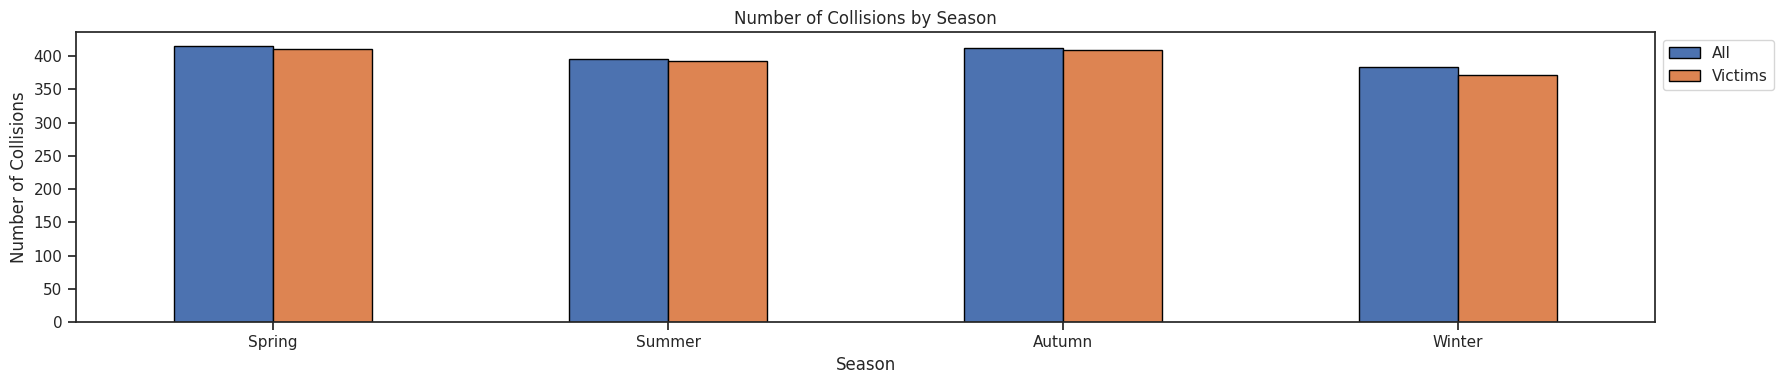

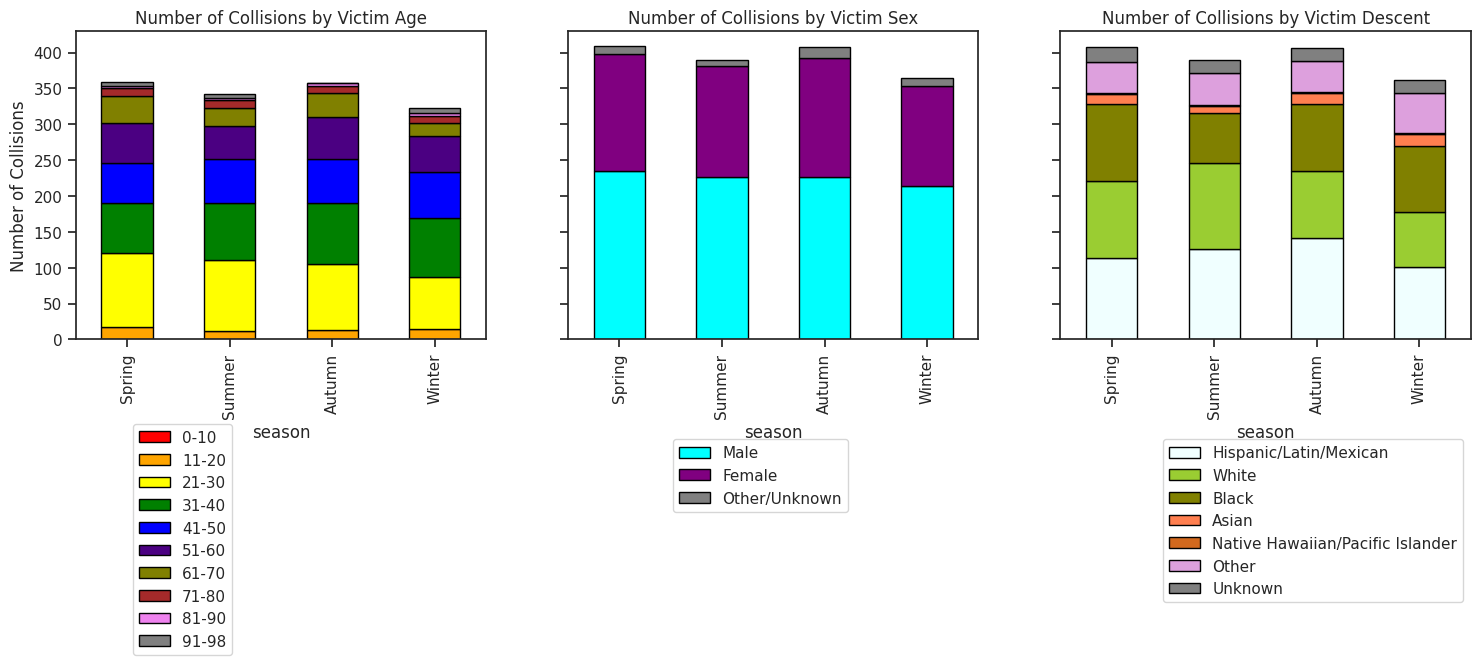

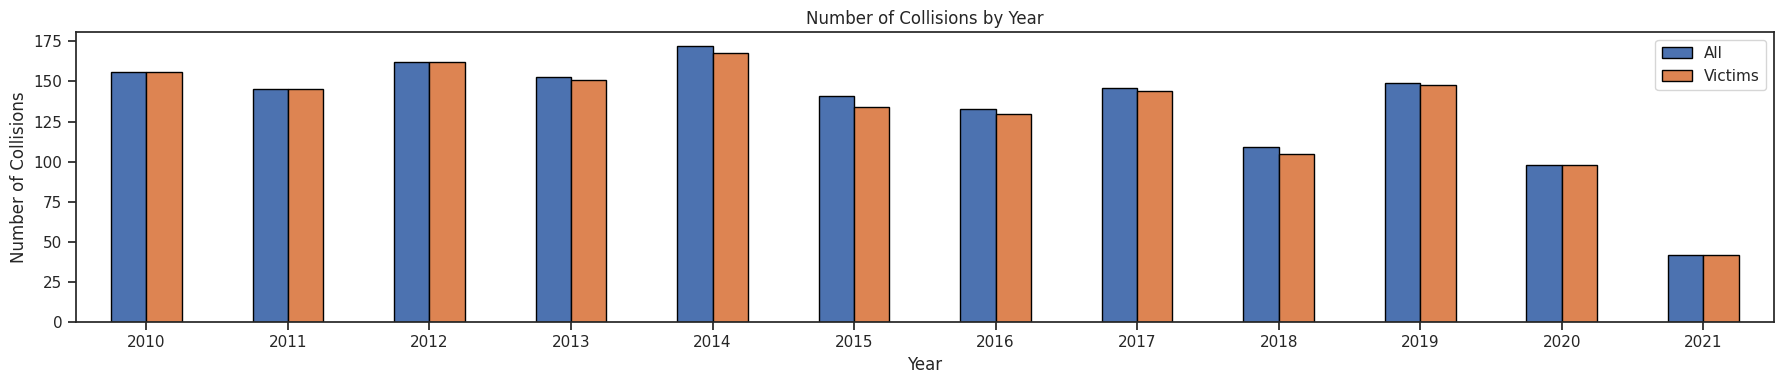

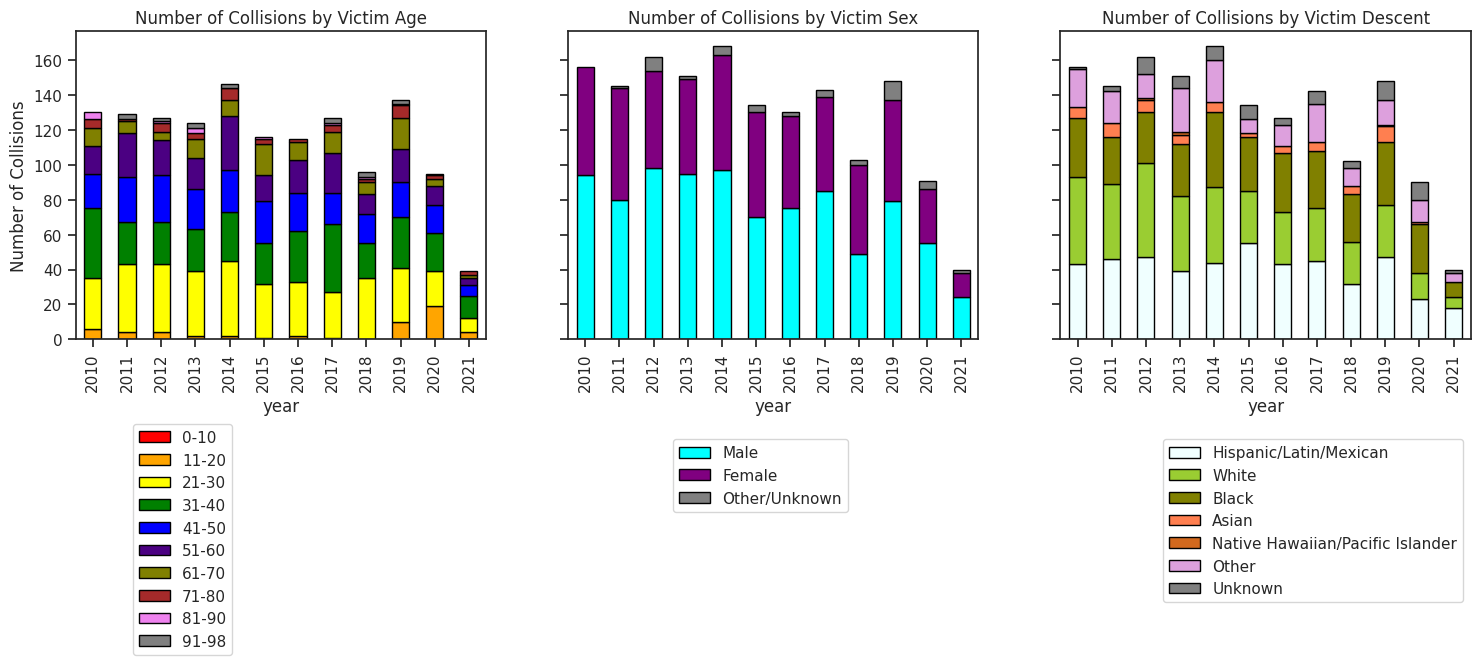

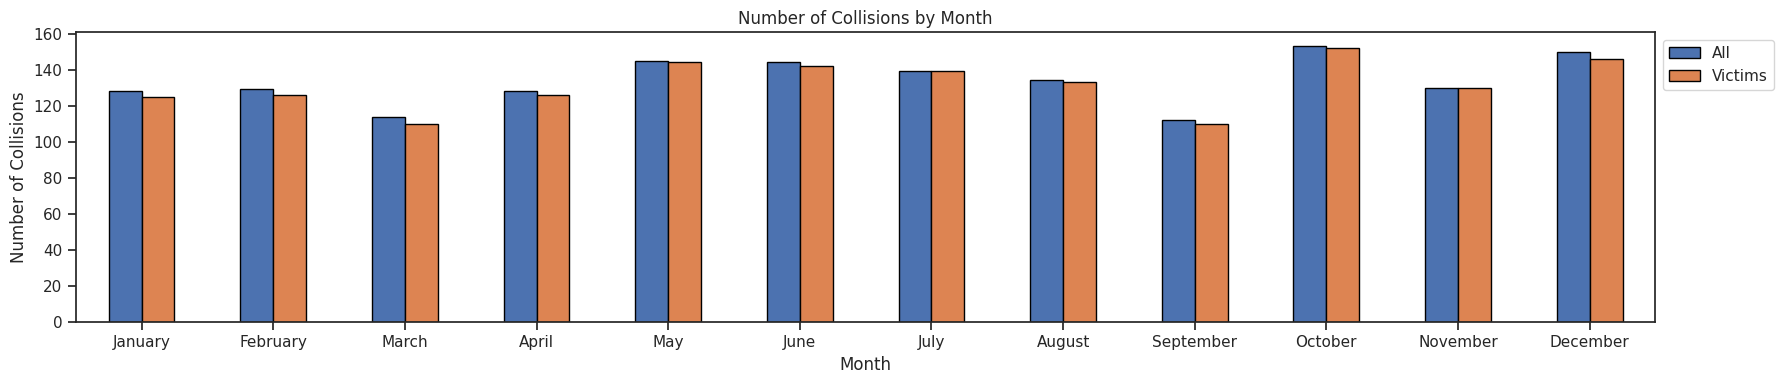

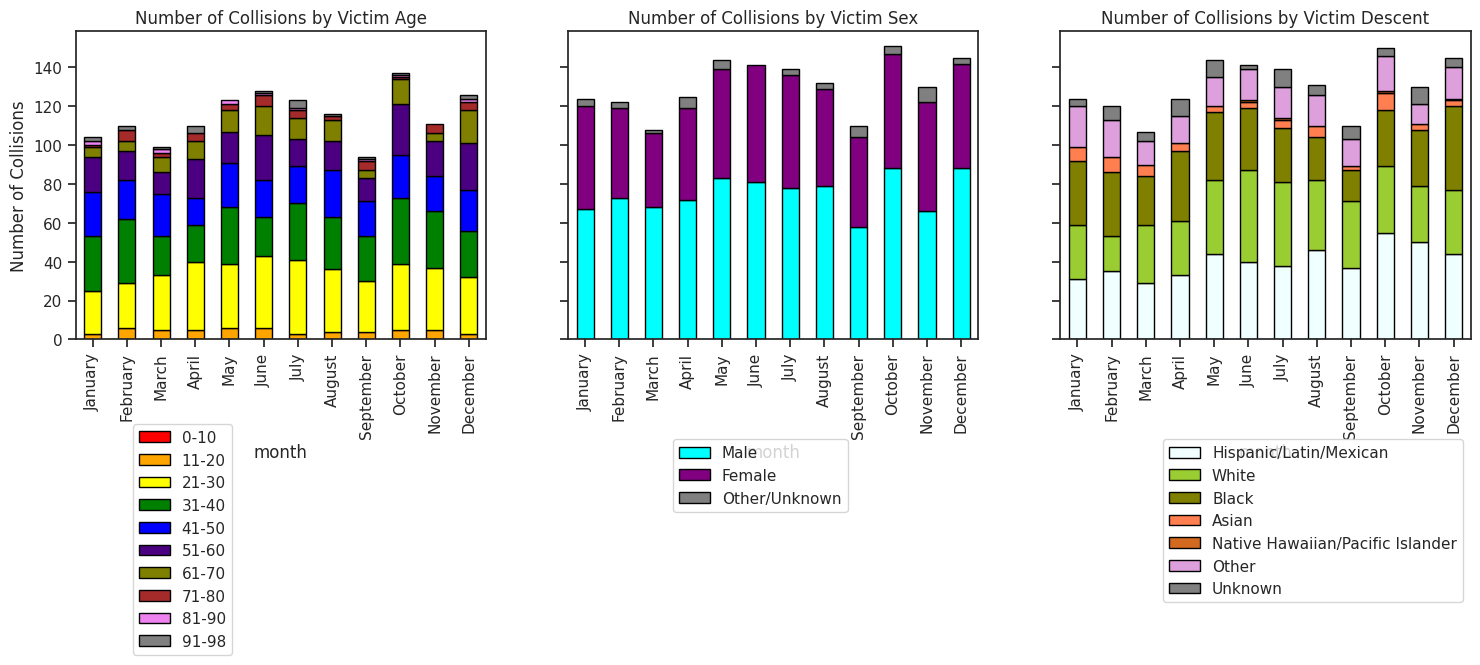

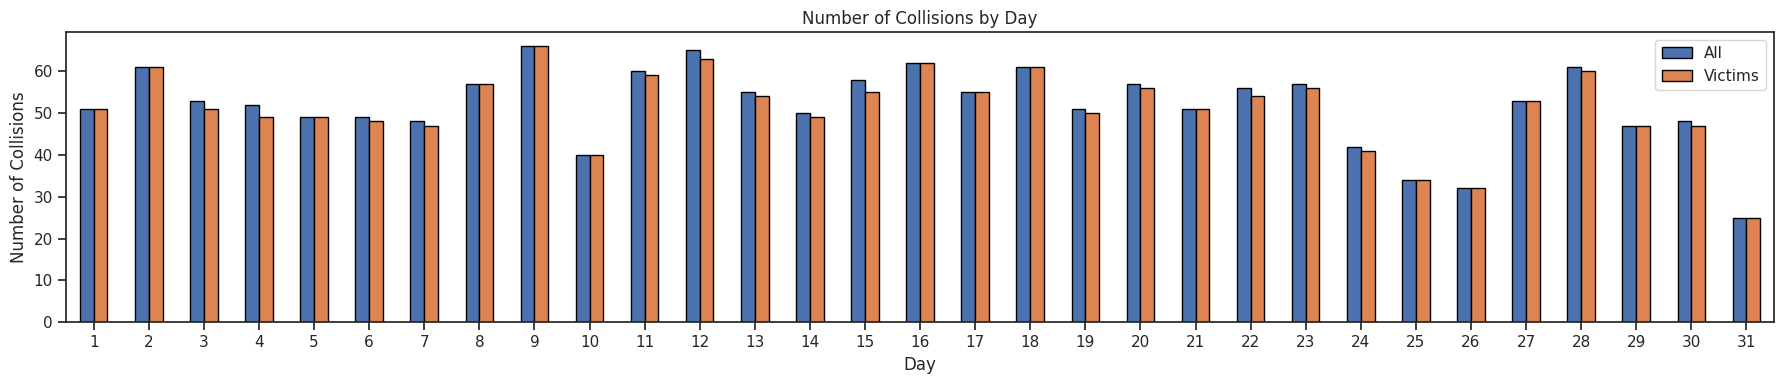

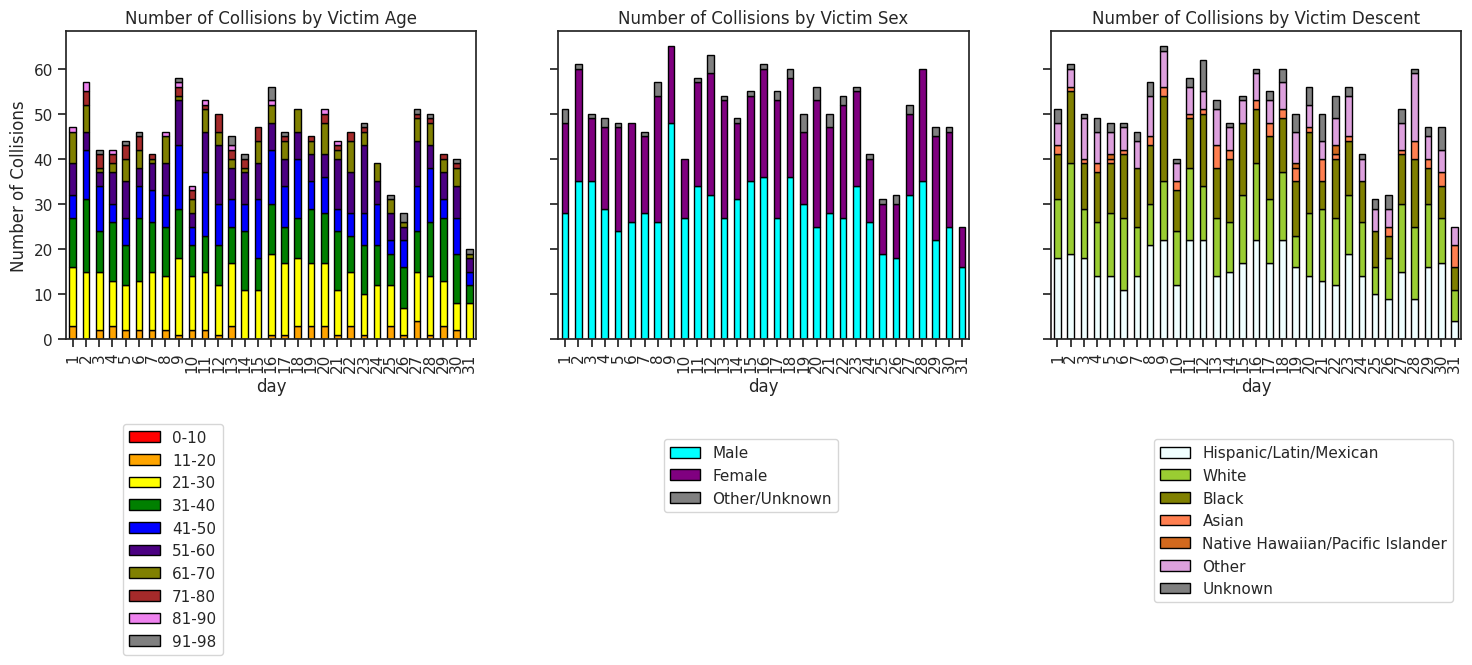

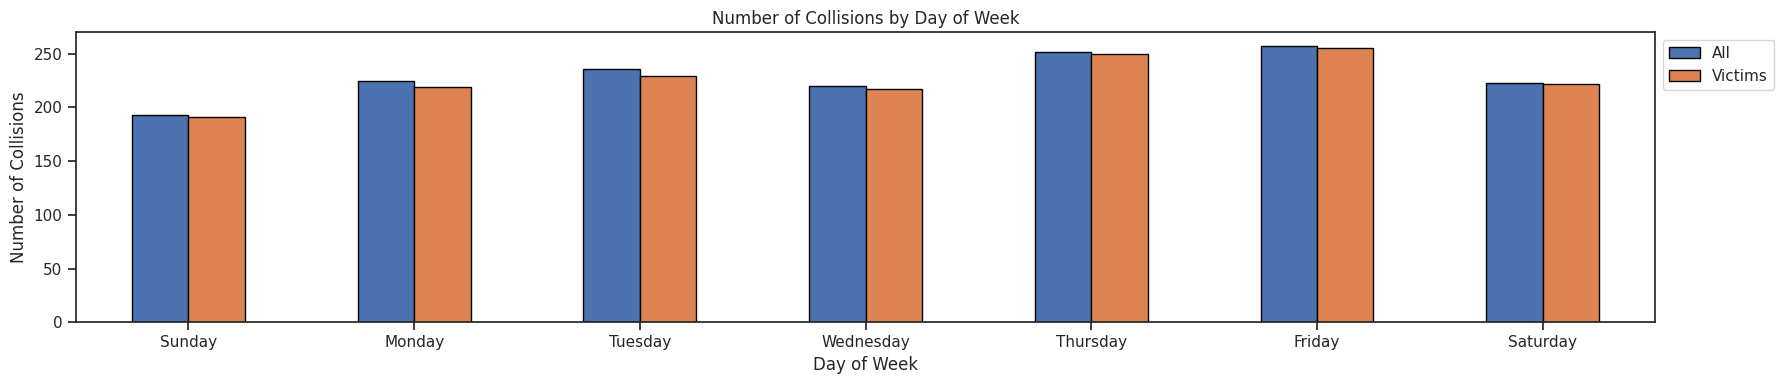

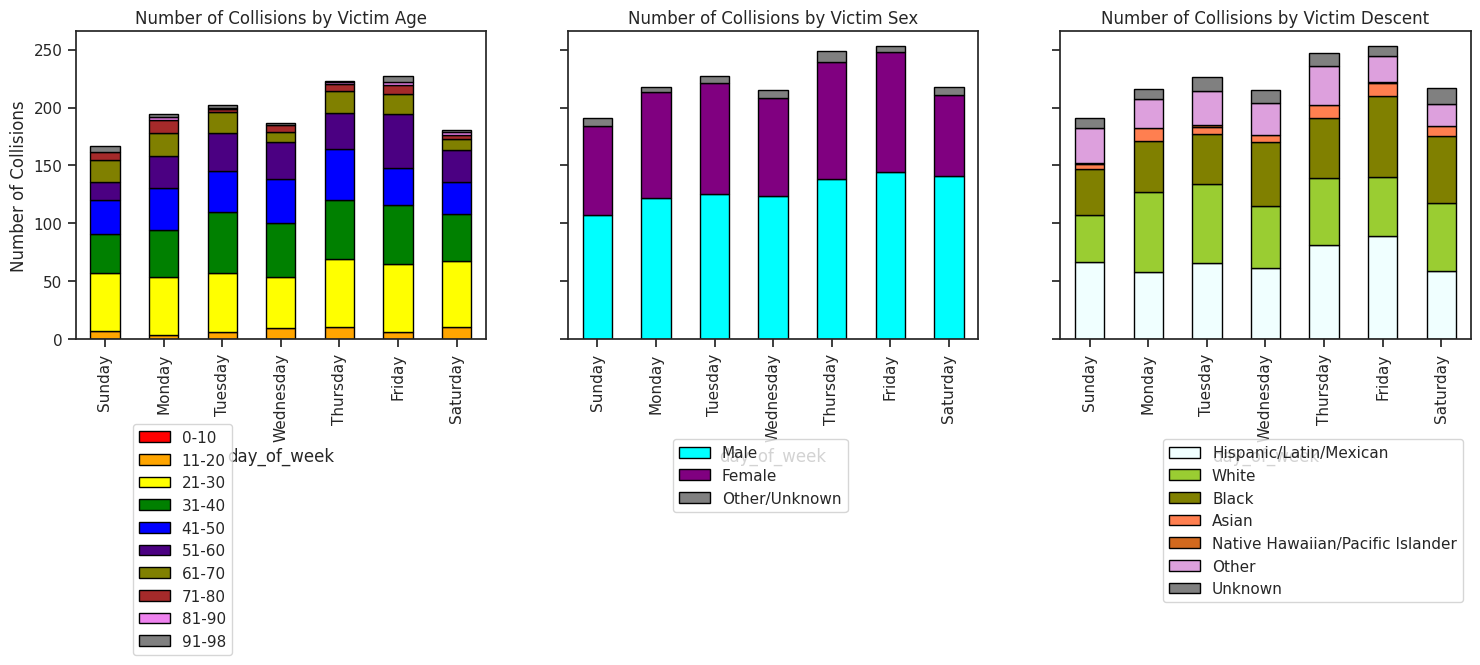

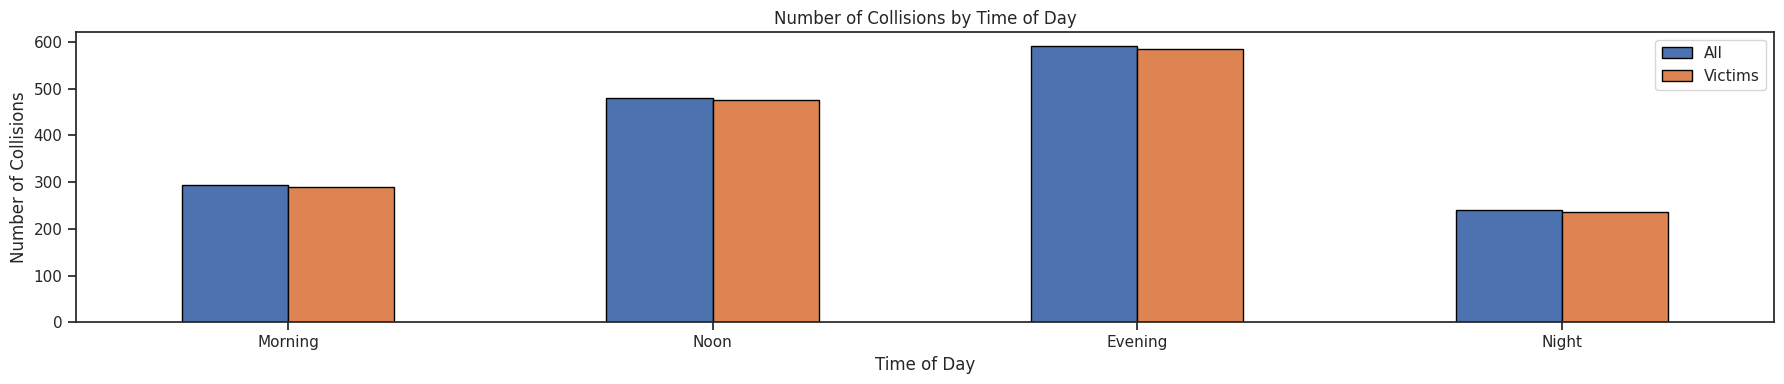

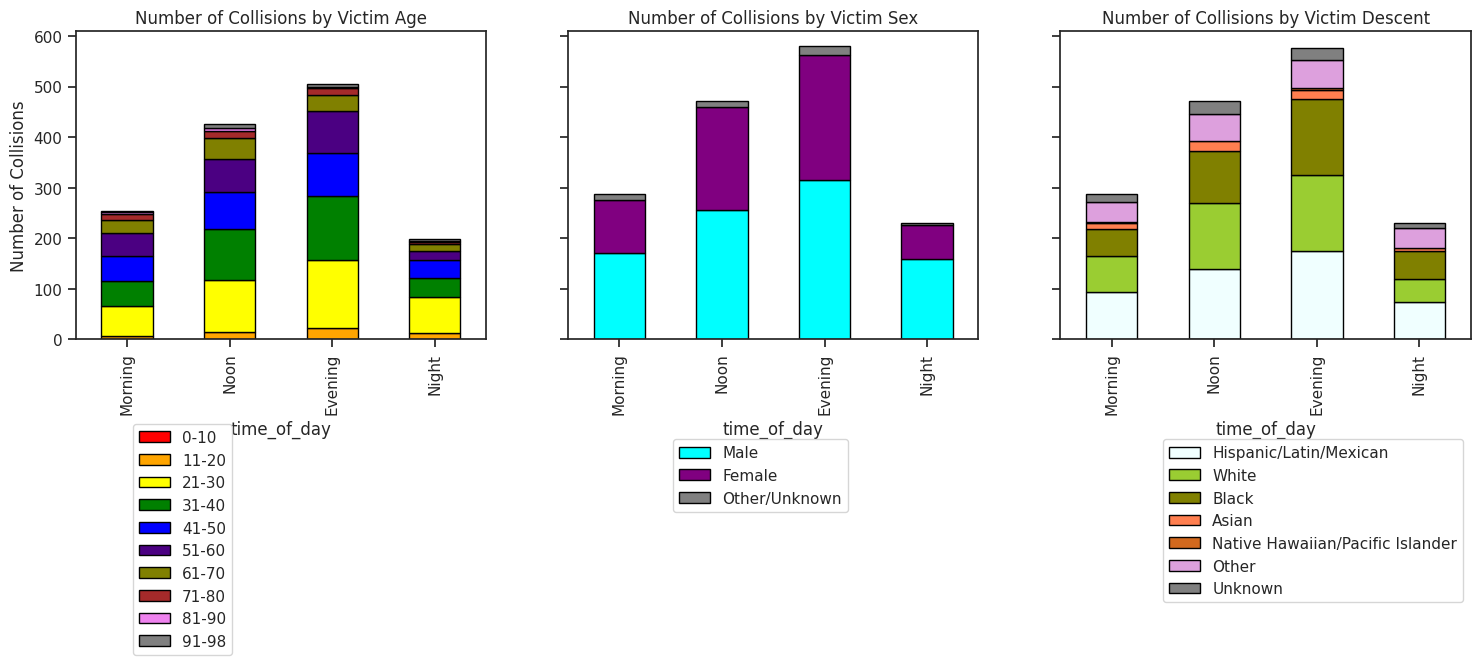

In [29]:
grapher(season_ui,"Season")
grapher(year_ui,"Year")
grapher(month_ui,"Month")
grapher(day_ui,"Day")
grapher(dow_ui,"Day of Week")
grapher(tod_ui,"Time of Day")

I see a similar story in terms of the shape of most of the graphs, so I'm only going to highlight the key differences I see:


1.   The number of collisions seem to stay around the same, or even be dropping a tiny bit in terms of trends. The full dataset looks like it is relatively flat, but it increases towards 2015-2019.
2.   The summer and autumn months seem to have slightly more collisions as compared to the full dataset that looks to remain relatively flat.
3.   The 10th and 24-26 in the months have slightly less collisions (about 10-20) compared to surrounding days, but it looks to be relatively flat in the full dataset (The 31st has less collisions in both but not every month has a 31st).



### Location, Location, Location

In [30]:
dfin_ui[["intersection_clean", "location"]].value_counts()

,,count
intersection_clean,location,
"LA BREA AV, STOCKER ST","(33.9971, -118.3578)",42
"LA CIENEGA BL, IMPERIAL HY","(33.9309, -118.37)",41
"LINCOLN BL, MINDANAO WY","(33.9805, -118.439)",39
"FEDERAL AV, WILSHIRE BL","(34.0508, -118.4592)",37
"LINCOLN BL, MINDANAO WY","(33.9785, -118.4365)",33
...,...,...
"INDIANA, 5TH ST","(34.0293, -118.1923)",1
"INDIANA ST, S LANCASTER AV","(34.06, -118.1926)",1
"INDIANA ST, OLYMPIC","(34.0189, -118.1922)",1


The top 5 most dangerous dangerous intersections are different because the top 5 in the full dataset were in the incorporated areas.

In [31]:
lat_ui = dfin_ui["latitude"][np.logical_not(np.isnan(dfin_ui["latitude"]))]
lon_ui = dfin_ui["longitude"][np.logical_not(np.isnan(dfin_ui["longitude"]))]

top5_ui = dfin_ui[["intersection_clean","latitude","longitude"]].value_counts().reset_index(name="counts").head()

map_ui = folium.Map(location=[dfin_ui["latitude"].mean(),dfin_ui["longitude"].mean()],
                 zoom_start=10,
                 control_scale=True)
HeatMap(list(zip(lat_ui, lon_ui))).add_to(map_ui)

for row in top5_ui.itertuples():
    folium.Marker([row.latitude, row.longitude],
                 popup=row.intersection_clean,
                 icon=folium.Icon(color="red")).add_to(map_ui)
map_ui

In [32]:
dfin_ui_p2015[["intersection_clean","latitude","longitude"]].value_counts()[:10]

,,,count
intersection_clean,latitude,longitude,
"LA BREA AV, STOCKER ST",33.9971,-118.3578,23
"LINCOLN BL, MINDANAO WY",33.9785,-118.4365,23
"LA CIENEGA BL, IMPERIAL HY",33.9309,-118.3700,22
"FEDERAL AV, WILSHIRE BL",34.0508,-118.4592,21
"LINCOLN BL, MINDANAO WY",33.9805,-118.4390,21
"LA BREA, STOCKER",33.9971,-118.3578,19
"FOOTHILL BL, SIERRA HY",34.3374,-118.5042,15
"NORMANDIE AV, LOMITA BL",33.7978,-118.2975,14
"CULVER BL, LINCOLN BL",33.9759,-118.4330,14


The top 5 most dangerous intersections are the top 5 before Vision Zero was enacted.

In [33]:
dfin_ui_2015p[["intersection_clean","latitude","longitude"]].value_counts()[:10]

,,,count
intersection_clean,latitude,longitude,
"CENTINELA AV, LA TIJERA BL",33.9773,-118.3732,19
"LA BREA AV, STOCKER ST",33.9971,-118.3578,19
"LA CIENEGA BL, IMPERIAL HY",33.9309,-118.3700,19
"LINCOLN BL, MINDANAO WY",33.9805,-118.4390,18
"CENTINELA AV, ALVERN ST",33.9771,-118.3768,16
"FEDERAL AV, WILSHIRE BL",34.0508,-118.4592,16
"OLYMPIC BL, INDIANA ST",34.0189,-118.1922,14
"108TH ST, WESTERN AV",33.9382,-118.3090,13
"LOMITA BL, VERMONT AV",33.7978,-118.2908,11


Interestingly, the top 5 most dangerous intersections are different after Vision Zero was signed.

In [34]:
dfin_ui[["premise_code","premise_description"]].value_counts()

,,count
premise_code,premise_description,
101.0,STREET,1530
108.0,PARKING LOT,41
102.0,SIDEWALK,13
104.0,DRIVEWAY,5
110.0,FREEWAY,4
116.0,OTHER/OUTSIDE,3
103.0,ALLEY,2
122.0,"VEHICLE, PASSENGER/TRUCK",1
212.0,TRANSPORTATION FACILITY (AIRPORT),1


Streets are still the most dangerous in the unincorporated areas, then parking lots, and sidewalks.

In [35]:
precincts_ui = dfin_ui[["rd_prec", "rd_aprec"]].value_counts(ascending=True).reset_index(name="counts")
precincts_ui

,rd_prec,rd_aprec,counts
0,16.0,FOOTHILL,1
1,7.0,WILSHIRE,3
2,20.0,OLYMPIC,3
3,1.0,CENTRAL,4
4,17.0,DEVONSHIRE,5
5,19.0,MISSION,22
6,13.0,NEWTON,25
7,15.0,NORTH HOLLYWOOD,68
8,12.0,77TH STREET,104
9,4.0,HOLLENBECK,119


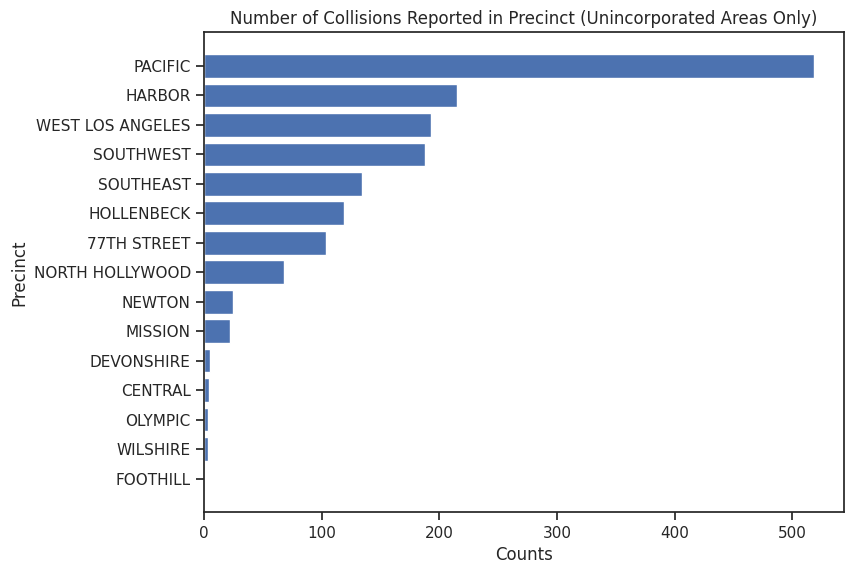

In [36]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.barh(precincts_ui["rd_aprec"],precincts_ui["counts"])

ax.set_xlabel('Counts')
ax.set_ylabel('Precinct')
ax.set_title('Number of Collisions Reported in Precinct (Unincorporated Areas Only)')
plt.show()

There are differences in which precincts are the most dangerous (in terms of traffic collisions) in the unincorporated areas as compared to the full dataset. Pacific has more than twice the number of collisions as compared to the second most: Harbor.

In [37]:
dfin_ui[["rd_prec", "rd_aprec","rd_bureau"]].value_counts()

,,,count
rd_prec,rd_aprec,rd_bureau,
14.0,PACIFIC,WEST BUREAU,518
5.0,HARBOR,SOUTH BUREAU,215
8.0,WEST LOS ANGELES,WEST BUREAU,193
3.0,SOUTHWEST,SOUTH BUREAU,188
18.0,SOUTHEAST,SOUTH BUREAU,134
4.0,HOLLENBECK,CENTRAL BUREAU,119
12.0,77TH STREET,SOUTH BUREAU,104
15.0,NORTH HOLLYWOOD,VALLEY BUREAU,68
13.0,NEWTON,CENTRAL BUREAU,25


In [38]:
precinct_ui_p2015 = dfin_ui_p2015[["rd_prec", "rd_aprec","rd_bureau"]].value_counts().reset_index(name="counts_p2015")
precinct_ui_p2015

,rd_prec,rd_aprec,rd_bureau,counts_p2015
0,14.0,PACIFIC,WEST BUREAU,253
1,5.0,HARBOR,SOUTH BUREAU,135
2,8.0,WEST LOS ANGELES,WEST BUREAU,125
3,3.0,SOUTHWEST,SOUTH BUREAU,116
4,18.0,SOUTHEAST,SOUTH BUREAU,71
5,4.0,HOLLENBECK,CENTRAL BUREAU,59
6,12.0,77TH STREET,SOUTH BUREAU,38
7,15.0,NORTH HOLLYWOOD,VALLEY BUREAU,26
8,13.0,NEWTON,CENTRAL BUREAU,18
9,19.0,MISSION,VALLEY BUREAU,16


In [39]:
precinct_ui_2015p = dfin_ui_2015p[["rd_prec", "rd_aprec","rd_bureau"]].value_counts().reset_index(name="counts_2015p")
precinct_ui_2015p

,rd_prec,rd_aprec,rd_bureau,counts_2015p
0,14.0,PACIFIC,WEST BUREAU,265
1,5.0,HARBOR,SOUTH BUREAU,80
2,3.0,SOUTHWEST,SOUTH BUREAU,72
3,8.0,WEST LOS ANGELES,WEST BUREAU,68
4,12.0,77TH STREET,SOUTH BUREAU,66
5,18.0,SOUTHEAST,SOUTH BUREAU,63
6,4.0,HOLLENBECK,CENTRAL BUREAU,60
7,15.0,NORTH HOLLYWOOD,VALLEY BUREAU,42
8,13.0,NEWTON,CENTRAL BUREAU,7
9,19.0,MISSION,VALLEY BUREAU,6


In [40]:
pd.merge(precinct_ui_p2015,precinct_ui_2015p, on=["rd_prec","rd_aprec","rd_bureau"], how="left")

,rd_prec,rd_aprec,rd_bureau,counts_p2015,counts_2015p
0,14.0,PACIFIC,WEST BUREAU,253,265.0
1,5.0,HARBOR,SOUTH BUREAU,135,80.0
2,8.0,WEST LOS ANGELES,WEST BUREAU,125,68.0
3,3.0,SOUTHWEST,SOUTH BUREAU,116,72.0
4,18.0,SOUTHEAST,SOUTH BUREAU,71,63.0
5,4.0,HOLLENBECK,CENTRAL BUREAU,59,60.0
6,12.0,77TH STREET,SOUTH BUREAU,38,66.0
7,15.0,NORTH HOLLYWOOD,VALLEY BUREAU,26,42.0
8,13.0,NEWTON,CENTRAL BUREAU,18,7.0
9,19.0,MISSION,VALLEY BUREAU,16,6.0


There are some precincts  where the number of traffic collisions increased, and some which have decreased since the signing of Vision Zero. Overall , there doesn't seem to be a large difference in the number of collisions except in 77th Street, South Bureau.

### MO Codes

In [41]:
mo_fin_ui = mo_fin.merge(dfin_ui['dr_number'], on=['dr_number'],how='inner')
mo_fin_ui

,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic,vs
0,191418571,mo_code_0,3003,T/C - Veh vs Ped,3003,True,True
1,191516179,mo_code_0,3004,T/C - Veh vs Veh,3004,True,True
2,170414237,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101,True,False
3,191415730,mo_code_0,3102,T/C - PCF (B) Other Improper Driving,3102,True,False
4,191514266,mo_code_0,3004,T/C - Veh vs Veh,3004,True,True
...,...,...,...,...,...,...,...
8219,140806145,mo_code_9,1300,Vehicle involved,1300,False,False
8220,141406946,mo_code_9,1300,Vehicle involved,1300,False,False
8221,211415031,mo_code_9,4027,T/C - West Traffic (WTD),4027,True,False
8222,211422393,mo_code_9,4027,T/C - West Traffic (WTD),4027,True,False


In [42]:
mo_fin_ui[mo_fin_ui["vs"]]["code_def"].value_counts()

,count
code_def,
T/C - Veh vs Veh,713
T/C - Veh vs Parked Veh,197
T/C - Veh vs Fixed Object,118
T/C - Veh vs Ped,61
T/C - Veh vs Bike,41
T/C - Veh vs M/C,19
T/C - Veh vs Other Object,5
T/C - Veh vs Animal,1
T/C - Bike vs Other,1


Most traffic collisions in unincorporated areas are vehicles vs. vehicles.

In [43]:
victim_dttm_ui = dfin_ui[["dr_number", "victim","dttm_occurred"]]
mo_fin_vict_ui = pd.merge(mo_fin_ui,
                       victim_dttm_ui,
                       on = "dr_number",
                       how = "left")
mo_fin_vict_ui

,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic,vs,victim,dttm_occurred
0,191418571,mo_code_0,3003,T/C - Veh vs Ped,3003,True,True,True,2019-08-22 09:25:00
1,191516179,mo_code_0,3004,T/C - Veh vs Veh,3004,True,True,True,2019-08-25 07:20:00
2,170414237,mo_code_0,3101,T/C - PCF (A) In the Narrative,3101,True,False,True,2017-08-20 02:00:00
3,191415730,mo_code_0,3102,T/C - PCF (B) Other Improper Driving,3102,True,False,True,2019-07-08 17:10:00
4,191514266,mo_code_0,3004,T/C - Veh vs Veh,3004,True,True,True,2019-07-16 16:00:00
...,...,...,...,...,...,...,...,...,...
8219,140806145,mo_code_9,1300,Vehicle involved,1300,False,False,True,2014-02-27 08:00:00
8220,141406946,mo_code_9,1300,Vehicle involved,1300,False,False,True,2014-02-03 23:00:00
8221,211415031,mo_code_9,4027,T/C - West Traffic (WTD),4027,True,False,True,2021-07-14 15:40:00
8222,211422393,mo_code_9,4027,T/C - West Traffic (WTD),4027,True,False,True,2021-12-03 12:35:00


In [44]:
code_victs_ui = mo_fin_vict_ui[mo_fin_vict_ui["vs"]][["code_def","victim"]].value_counts().sort_index()\
    .reset_index(name="NumRecords")
code_victs_ui

,code_def,victim,NumRecords
0,T/C - Bike vs Other,True,1
1,T/C - Veh vs Animal,True,1
2,T/C - Veh vs Bike,True,41
3,T/C - Veh vs Fixed Object,False,13
4,T/C - Veh vs Fixed Object,True,105
5,T/C - Veh vs M/C,True,19
6,T/C - Veh vs Other Object,False,1
7,T/C - Veh vs Other Object,True,4
8,T/C - Veh vs Parked Veh,False,2
9,T/C - Veh vs Parked Veh,True,195


In [45]:
code_victs_ui_wide = pd.pivot(code_victs_ui, index = "code_def", columns="victim", values="NumRecords").reset_index()

code_victs_ui_wide.rename(columns={False:"Falses",True:"Trues"},inplace=True)

code_victs_ui_wide["ranked"] = code_victs_ui_wide["Trues"].rank()

code_victs_ui_wide.set_index("ranked", inplace=True)

code_victs_ui_wide = code_victs_ui_wide.sort_index()

code_victs_ui_wide.fillna(0,inplace=True)

code_victs_ui_wide["code_def"] = code_victs_ui_wide["code_def"].str.replace("T/C - ","")
code_victs_ui_wide["code_def"] = code_victs_ui_wide["code_def"].str.replace("M/C","Motorcycle")
code_victs_ui_wide["code_def"] = code_victs_ui_wide["code_def"].str.replace("Veh","Vehicle")
code_victs_ui_wide["code_def"] = code_victs_ui_wide["code_def"].str.replace("Ped","Pedestrian")
code_victs_ui_wide

victim,code_def,Falses,Trues
ranked,,,
1.5,Bike vs Other,0.0,1.0
1.5,Vehicle vs Animal,0.0,1.0
3.0,Vehicle vs Other Object,1.0,4.0
4.0,Vehicle vs Motorcycle,0.0,19.0
5.0,Vehicle vs Bike,0.0,41.0
6.0,Vehicle vs Pedestrian,1.0,60.0
7.0,Vehicle vs Fixed Object,13.0,105.0
8.0,Vehicle vs Parked Vehicle,2.0,195.0
9.0,Vehicle vs Vehicle,6.0,707.0


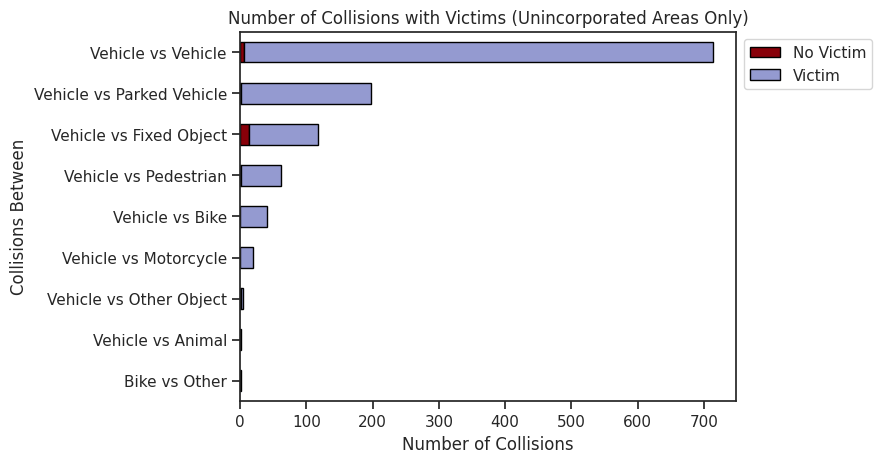

In [46]:
code_victs_ui_wide.plot(kind='barh',
                     stacked=True,
                     title="Number of Collisions with Victims (Unincorporated Areas Only)",
                     color = ["#880009","#949ad0"],
                     x = "code_def",
                     edgecolor="black")
plt.legend(['No Victim', 'Victim'], bbox_to_anchor =(1,1,0,0), ncol = 1)
plt.ylabel("Collisions Between")
plt.xlabel("Number of Collisions")
plt.show()

Similarly, most of the traffic collisions have a victim reported.

In [47]:
vs_ui = mo_fin_vict_ui[mo_fin_vict_ui["vs"]][["dr_number"]].value_counts().reset_index(name="NumVS")
vs_ui['NumVS'].value_counts()

,count
NumVS,
1,1140
2,8


Thankfully, most (~99.3) of these collisions only have 1 victim , with only 8 having 2.

In [48]:
mo_fin_vict_ui_p2015 = mo_fin_vict_ui[mo_fin_vict_ui["dr_number"].isin(dfin_ui_p2015["dr_number"])]
mo_fin_vict_ui_2015p = mo_fin_vict_ui[mo_fin_vict_ui["dr_number"].isin(dfin_ui_2015p["dr_number"])]

In [49]:
mult_ui_p2015 = mo_fin_vict_ui_p2015[mo_fin_vict_ui_p2015["vs"]][["dr_number"]].value_counts().reset_index(name="NumVS")
print(mult_ui_p2015["NumVS"].value_counts())
print("")
print(mult_ui_p2015["NumVS"].value_counts(normalize=True))

NumVS
1    475
2      3
Name: count, dtype: int64

NumVS
1    0.993724
2    0.006276
Name: proportion, dtype: float64


In [50]:
mult_ui_2015p = mo_fin_vict_ui_2015p[mo_fin_vict_ui_2015p["vs"]][["dr_number"]].value_counts().reset_index(name="NumVS")
print(mult_ui_2015p["NumVS"].value_counts())
print("")
print(mult_ui_2015p["NumVS"].value_counts(normalize=True))

NumVS
1    665
2      5
Name: count, dtype: int64

NumVS
1    0.992537
2    0.007463
Name: proportion, dtype: float64


This percentage does not change much when comparing Pre-/Post- Vision Zero.

In [51]:
mo_fin_vict_ui.loc[:,"injury"] = mo_fin_vict_ui["code_def"].str.contains("Injury|injury", na=False)
mo_fin_vict_ui[mo_fin_vict_ui["injury"]]["code_def"].value_counts()

,count
code_def,
T/C - (N) Non Injury,466
T/C - (C) Complaint of Injury,367
T/C - (B) Visible Injury,137
T/C - (A) Severe Injury,34
T/C - (K) Fatal Injury,4


Thankfully, severe and fatal injuries number the least in the injuries. Furthermore, 46.2% of the collisions are recorded as not having injuries.

In [52]:
injuries_ui = mo_fin_vict_ui[mo_fin_vict_ui["injury"]]
injuries_ui["code_def"] = injuries_ui["code_def"].str[10:]
injuries_ui

<ipython-input-52-0866ef3b5494>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,dr_number,orig_var,mo_code,code_def,mo_code_clean,traffic,vs,victim,dttm_occurred,injury
73,191229397,mo_code_0,3026,Complaint of Injury,3026,True,False,True,2019-12-21 01:50:00,True
98,200807013,mo_code_0,3028,Non Injury,3028,True,False,True,2020-03-07 00:55:00,True
118,201416122,mo_code_0,3028,Non Injury,3028,True,False,True,2020-08-25 21:55:00,True
178,120517560,mo_code_0,3025,Visible Injury,3025,True,False,True,2012-10-08 17:00:00,True
243,120324750,mo_code_0,3028,Non Injury,3028,True,False,True,2012-11-11 17:40:00,True
...,...,...,...,...,...,...,...,...,...,...
7967,191408113,mo_code_8,3028,Non Injury,3028,True,False,True,2019-03-06 20:00:00,True
8045,150809958,mo_code_8,3025,Visible Injury,3025,True,False,True,2015-05-24 16:00:00,True
8101,161523802,mo_code_8,3028,Non Injury,3028,True,False,True,2016-11-05 02:15:00,True
8199,210415765,mo_code_8,3028,Non Injury,3028,True,False,True,2021-12-11 08:20:00,True


In [53]:
numinjury_ui = injuries_ui.groupby("dr_number").agg("count").reset_index()
numinjury_ui["injury"].value_counts()

,count
injury,
1,1008


In [54]:
injuries_ui_p2015 = injuries_ui[injuries_ui["dr_number"].isin(dfin_ui_p2015["dr_number"])]
injuries_ui_2015p = injuries_ui[injuries_ui["dr_number"].isin(dfin_ui_2015p["dr_number"])]

In [55]:
print(injuries_ui_p2015["code_def"].value_counts())
print("")
print(injuries_ui_p2015["code_def"].value_counts(normalize=True))
print("-----------------------------------------")
print(injuries_ui_2015p["code_def"].value_counts())
print("")
print(injuries_ui_2015p["code_def"].value_counts(normalize=True))

code_def
Complaint of Injury    137
Non Injury             136
Visible Injury          69
Severe Injury           13
Fatal Injury             1
Name: count, dtype: int64

code_def
Complaint of Injury    0.384831
Non Injury             0.382022
Visible Injury         0.193820
Severe Injury          0.036517
Fatal Injury           0.002809
Name: proportion, dtype: float64
-----------------------------------------
code_def
Non Injury             330
Complaint of Injury    230
Visible Injury          68
Severe Injury           21
Fatal Injury             3
Name: count, dtype: int64

code_def
Non Injury             0.506135
Complaint of Injury    0.352761
Visible Injury         0.104294
Severe Injury          0.032209
Fatal Injury           0.004601
Name: proportion, dtype: float64


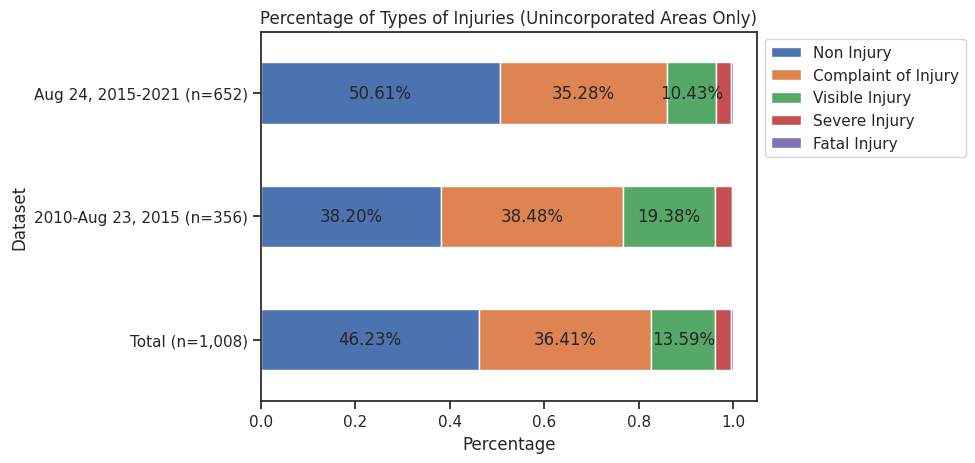

In [56]:
inj_cnt_tot_ui = injuries_ui["code_def"].value_counts().sum()
inj_cnt_ui_p2015 = injuries_ui_p2015["code_def"].value_counts().sum()
inj_cnt_ui_2015p = injuries_ui_2015p["code_def"].value_counts().sum()

inj_total_ui = injuries_ui["code_def"].value_counts(normalize=True).reset_index(name="Total")
inj_ui_p2015 = injuries_ui_p2015["code_def"].value_counts(normalize=True).reset_index(name="Pre-VisionZero")
inj_ui_2015p = injuries_ui_2015p["code_def"].value_counts(normalize=True).reset_index(name="Post-VisionZero")

tot_ui_p2015 = pd.merge(inj_total_ui,
                     inj_ui_p2015,
                     on="code_def",
                     how="left")

tot_ui_p2015_2015p = pd.merge(tot_ui_p2015,
                          inj_ui_2015p,
                           on="code_def",
                           how="left")
tot_ui_p2015_2015p

inj_pct_ui = tot_ui_p2015_2015p.loc[:,["code_def","Total","Pre-VisionZero","Post-VisionZero"]]
inj_pct_ui
inj_pct_t_ui = inj_pct_ui.T
inj_pct_t_ui.columns = inj_pct_t_ui.iloc[0]
inj_pct_t_ui.drop(index="code_def", inplace=True)
inj_pct_t_ui

inj_pct_t_ui.loc["Post-VisionZero","new_index"] = "Aug 24, 2015-2021"+" (n="+"{:,}".format(inj_cnt_ui_2015p)+")"
inj_pct_t_ui.loc["Pre-VisionZero","new_index"] = "2010-Aug 23, 2015"+" (n="+"{:,}".format(inj_cnt_ui_p2015)+")"
inj_pct_t_ui.loc["Total","new_index"] = "Total"+" (n="+"{:,}".format(inj_cnt_tot_ui)+")"
inj_pct_t_ui.set_index("new_index",inplace=True)

ax = inj_pct_t_ui.plot(kind="barh", stacked=True)
plt.title("Percentage of Types of Injuries (Unincorporated Areas Only)")
plt.xlabel("Percentage")
plt.ylabel("Dataset")
plt.legend(bbox_to_anchor=(1,1,0,0))

for bar in ax.patches:
    height = bar.get_height()
    width = bar.get_width()
    x = bar.get_x()
    y = bar.get_y()
    if width >= 0.05:
        label_text = "{:.2%}".format(width)
    else:
        label_text = ""
    label_x = x + width/2
    label_y = y + height/2
    ax.text(label_x, label_y, label_text, ha="center",va="center")

plt.show()

Overall, the proportions are similar to the full dataset. There are very few severe or fatal injuries.

### Regression Discontinuity

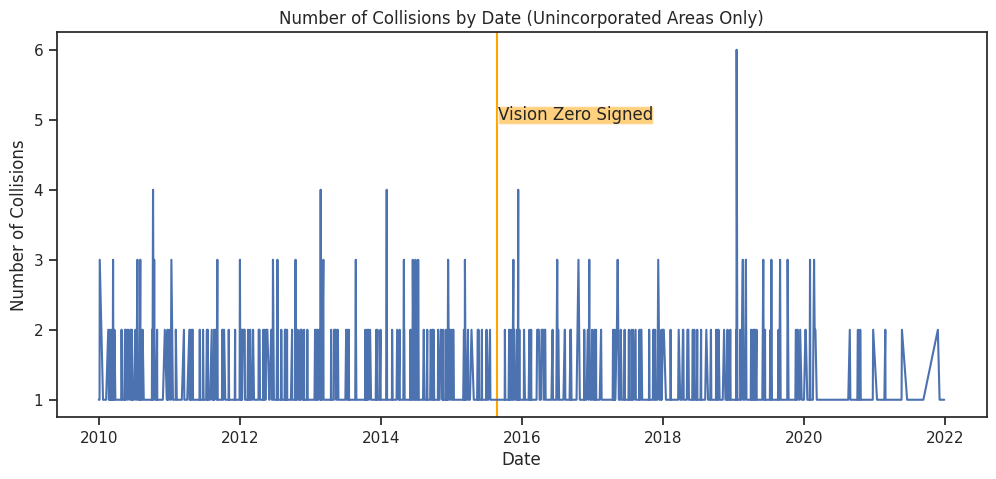

In [57]:
col_date_ui = pd.DataFrame(dfin_ui['dttm_occurred'].dt.date.value_counts().sort_index())

col_fig = plt.figure(figsize=(12,5))

plt.axvline(pd.to_datetime("2015-08-24"), color="orange")
plt.annotate("Vision Zero Signed", (pd.to_datetime("2015-08-30"),5),
             bbox=dict(boxstyle="square", fc="orange", alpha=0.5, pad=0))

plt.plot(col_date_ui)
plt.xlabel("Date")
plt.ylabel("Number of Collisions")
plt.title('Number of Collisions by Date (Unincorporated Areas Only)')
plt.show()

Generally, there are between 1 and 3 collisions a day. This pattern doesn't change due to the signing of Vision Zero.

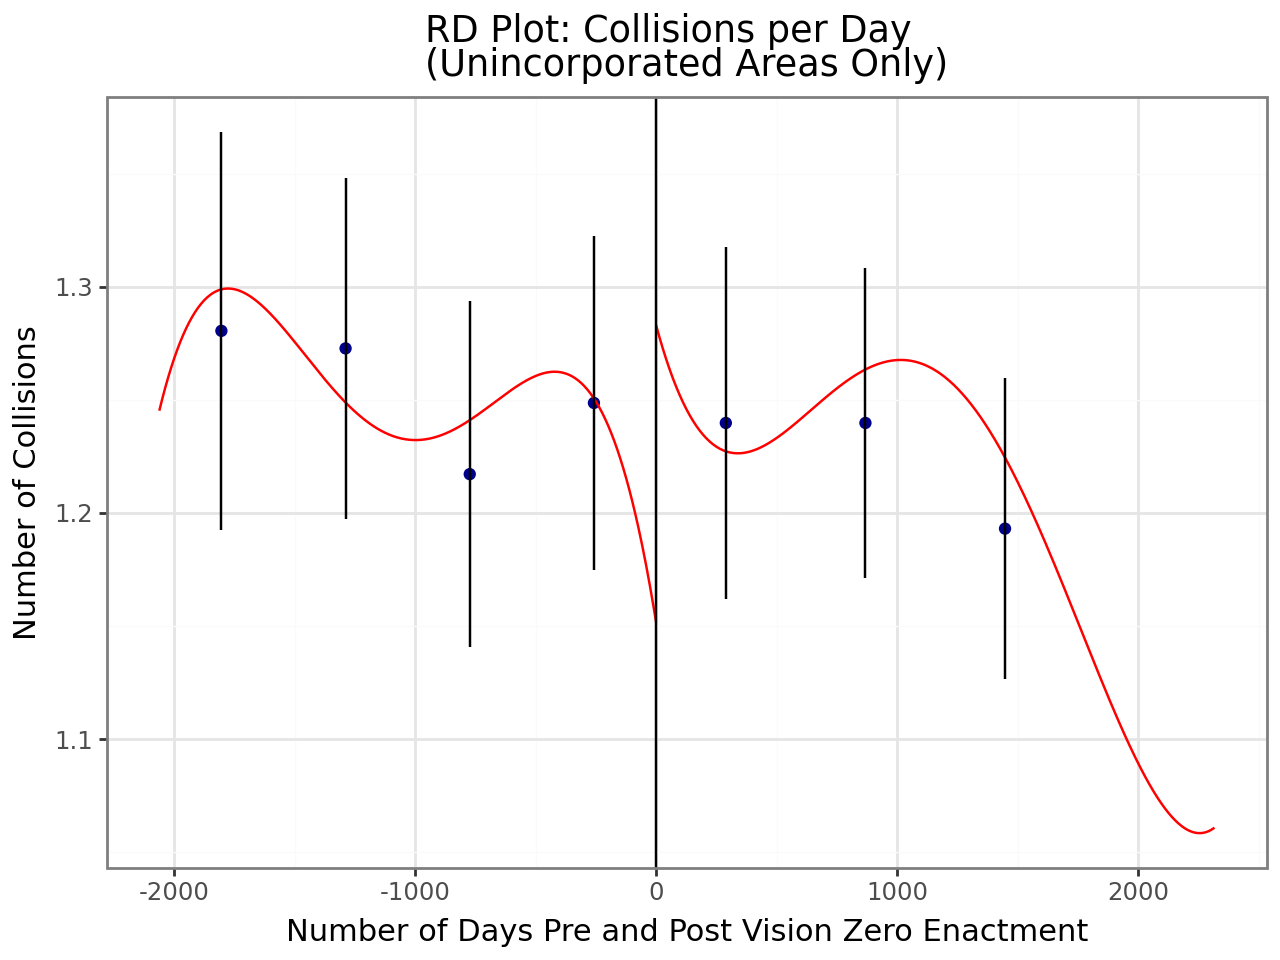

Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           696        601
Number of Unique Obs.            696        601
Number of Effective Obs.         199        171
Bandwidth Estimation          579.08     579.08
Bandwidth Bias               861.799    861.799
rho (h/b)                      0.672      0.672

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.077    0.103    0.751   4.527e-01     [-0.125, 0.28]
Bias-Corrected     0.104    0.103     1.01   3.127e-01    [-0.098, 0.306]
Robust             0.104    0

In [58]:
number_collisions_ui = dfin_ui.groupby(["pre_post_vision_zero"])["dr_number"].count().reset_index(name='Collisions')
number_collisions_ui

# y = number of collisions
# x = num of days pre-post Vision Zero

num_collisions_ui = number_collisions_ui["Collisions"]
days_coll_ui = number_collisions_ui.pre_post_vision_zero.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_ui, x=days_coll_ui, binselect="es", ci=95,
         title="RD Plot: Collisions per Day \n(Unincorporated Areas Only)",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

print(rdrobust(y=num_collisions_ui, x=days_coll_ui, all=True))

The regression discontinuity analysis shows there is no difference in the number of collisions pre-/post-Vision Zero.

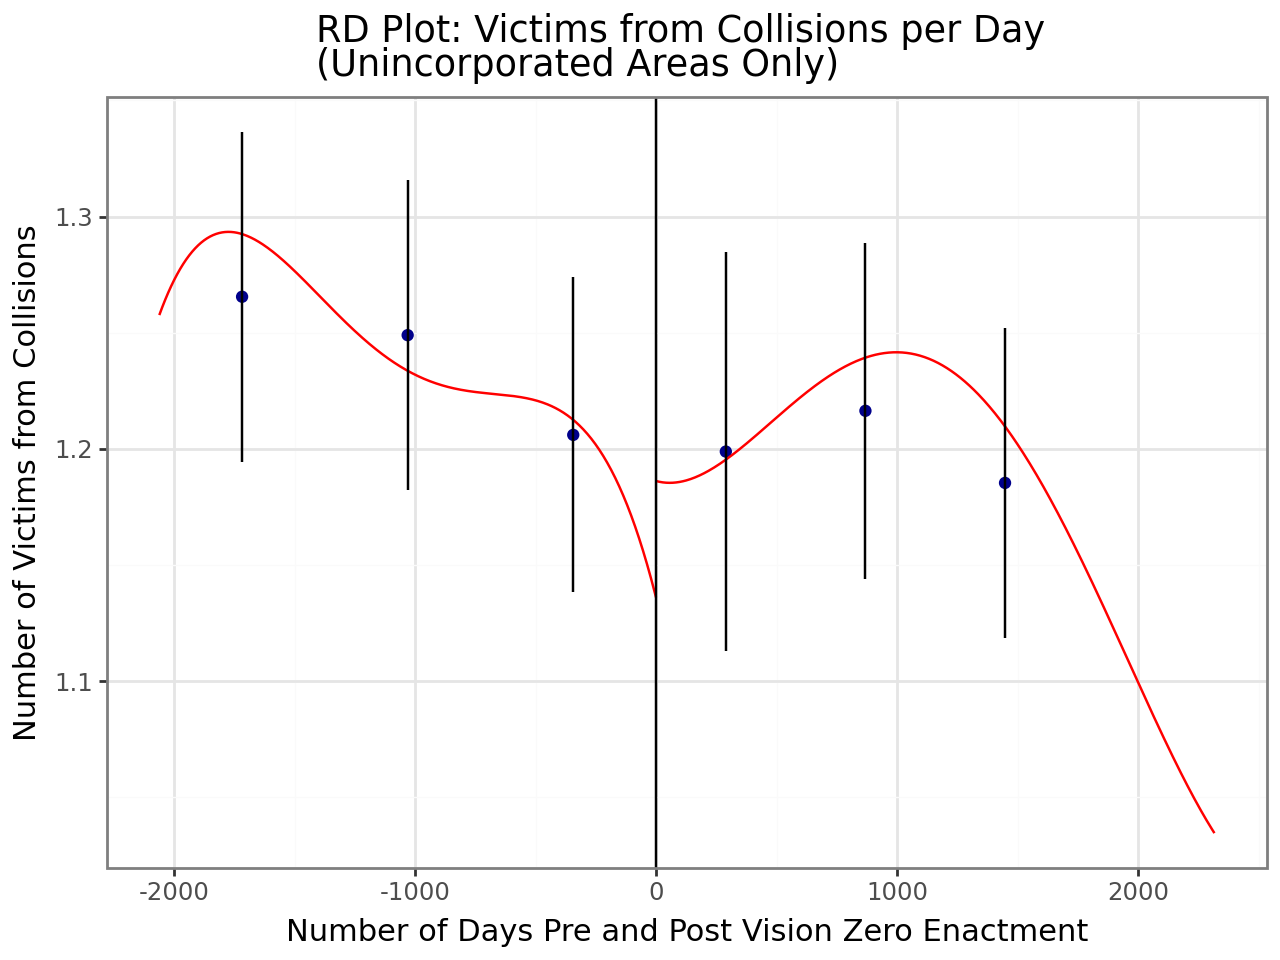

Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           696        601
Number of Unique Obs.            696        601
Number of Effective Obs.         219        189
Bandwidth Estimation          639.13     639.13
Bandwidth Bias               925.513    925.513
rho (h/b)                      0.691      0.691

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.019    0.109    0.172   8.637e-01    [-0.195, 0.233]
Bias-Corrected     0.029    0.109    0.265   7.911e-01    [-0.185, 0.243]
Robust             0.029    0

In [59]:
number_victims_ui = pd.DataFrame(dfin_ui.groupby(["pre_post_vision_zero"])["victim"].sum()).reset_index()
number_victims_ui

# y = number of victims
# x = num of days pre-post Vision Zero

num_victims_ui = number_victims_ui["victim"]
days_vic_ui = number_victims_ui.pre_post_vision_zero.dt.days

# # ### rdplot with 95% confidence intervals
rdplot(y=num_victims_ui, x=days_vic_ui, binselect="es", ci=95,
         title="RD Plot: Victims from Collisions per Day \n(Unincorporated Areas Only)",
         y_label="Number of Victims from Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

print(rdrobust(y=num_victims_ui, x=days_vic_ui, all=True))

There are no changes in the number of collisions with victims pre-/post- Vision Zero.

#### Pandemic

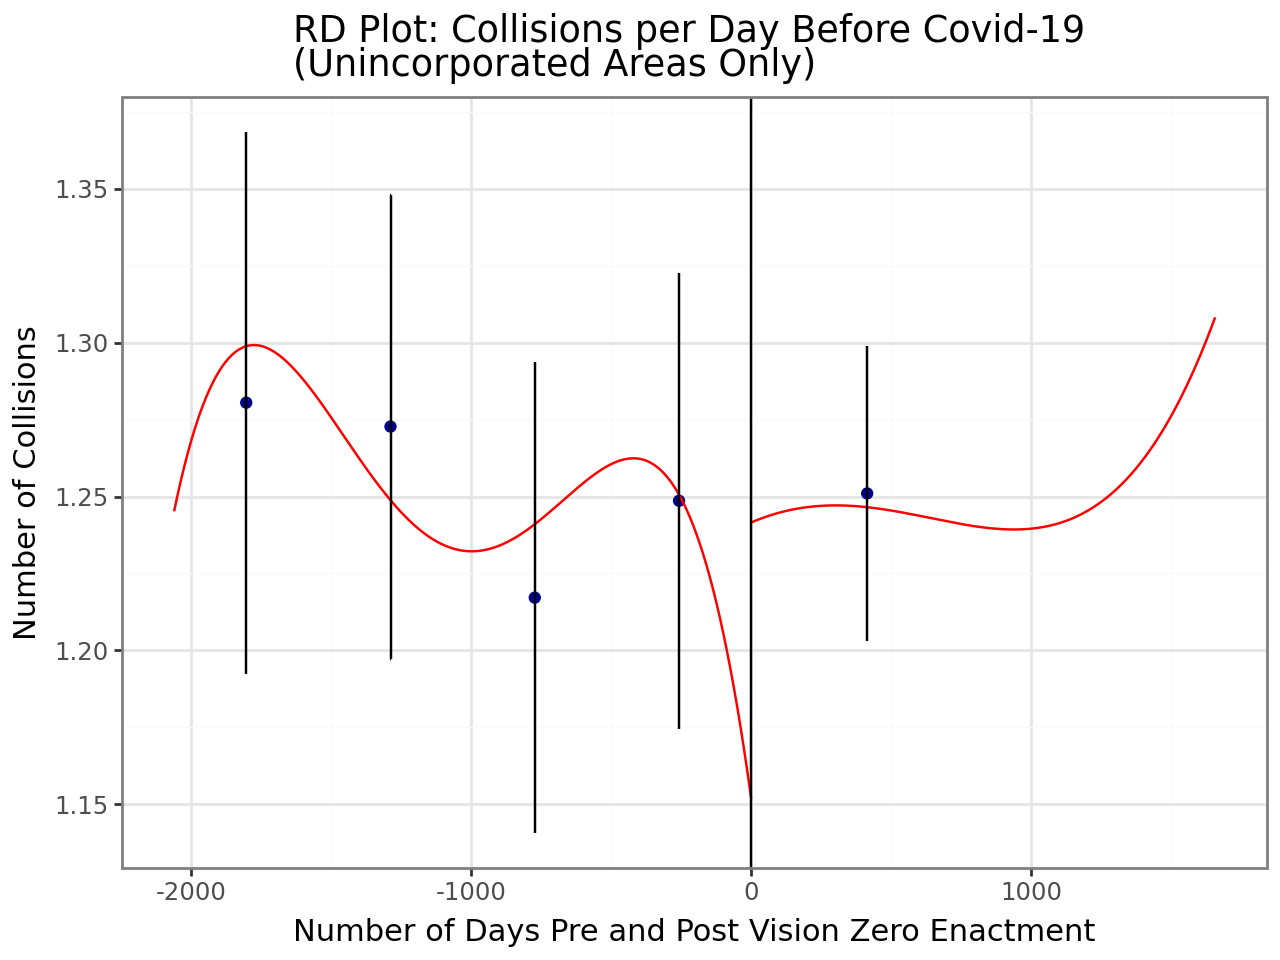

Call: rdrobust
Number of Observations:                  1194
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           696        498
Number of Unique Obs.            696        498
Number of Effective Obs.         163        140
Bandwidth Estimation         462.169    462.169
Bandwidth Bias               681.276    681.276
rho (h/b)                      0.678      0.678

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.095    0.107    0.887   3.750e-01    [-0.115, 0.304]
Bias-Corrected     0.121    0.107    1.134   2.567e-01     [-0.088, 0.33]
Robust             0.121    0

In [60]:
number_collisions_nocovid_ui = dfin_ui[dfin_ui["postcovid"] < pd.Timedelta(-1, unit='d')].groupby(["pre_post_vision_zero"])["dr_number"].count().reset_index(name='Collisions')

# y = number of collisions
# x = num of days pre-post Vision Zero

num_collisions_nocovid_ui = number_collisions_nocovid_ui["Collisions"]
days_coll_nocovid_ui = number_collisions_nocovid_ui.pre_post_vision_zero.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_nocovid_ui, x=days_coll_nocovid_ui, binselect="es", ci=95,
         title="RD Plot: Collisions per Day Before Covid-19 \n(Unincorporated Areas Only)",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

### rdrobust with all estimates
print(rdrobust(y=num_collisions_nocovid_ui, x=days_coll_nocovid_ui, all=True))

Despite what appears to be a downard trend on the left and an upward trend on the right, there does not appear to be a statistically significant difference in the number of collisions before Vision Zero was signed and afterwards (but before Covid-19 was declared a pandemic). This is a case where the graph is misleading because of the y-axis. There can only be a discrete number of accidents, and it is hovering between 1 and 2.

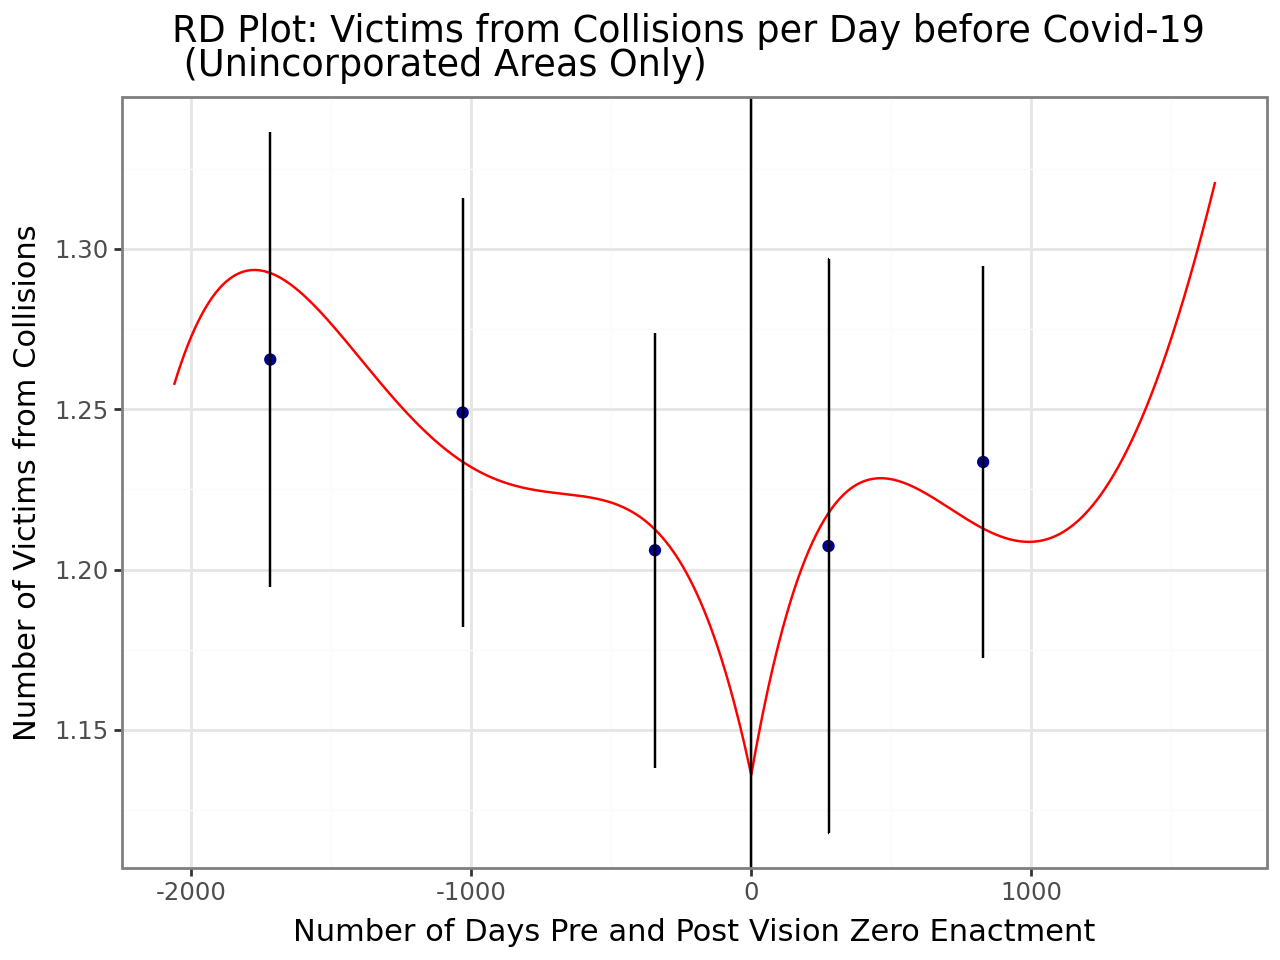

Call: rdrobust
Number of Observations:                  1194
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations           696        498
Number of Unique Obs.            696        498
Number of Effective Obs.         182        157
Bandwidth Estimation         516.338    516.338
Bandwidth Bias               738.946    738.946
rho (h/b)                      0.699      0.699

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       0.024    0.115    0.206   8.367e-01    [-0.202, 0.249]
Bias-Corrected     0.034    0.115    0.291   7.708e-01    [-0.192, 0.259]
Robust             0.034    0

In [61]:
number_victims_nocovid_ui = pd.DataFrame(dfin_ui[dfin_ui["postcovid"] < pd.Timedelta(-1, unit='d')].groupby(["pre_post_vision_zero"])["victim"].sum()).reset_index()

# y = number of victims
# x = num of days pre-post Vision Zero

num_victims_nocovid_ui = number_victims_nocovid_ui["victim"]
days_vic_nocovid_ui = number_victims_nocovid_ui.pre_post_vision_zero.dt.days

### rdplot with 95% confidence intervals
rdplot(y=num_victims_nocovid_ui, x=days_vic_nocovid_ui, binselect="es", ci=95,
         title="RD Plot: Victims from Collisions per Day before Covid-19 \n (Unincorporated Areas Only)",
         y_label="Number of Victims from Collisions",
         x_label="Number of Days Pre and Post Vision Zero Enactment")

### rdrobust with all estimates
print(rdrobust(y=num_victims_nocovid_ui, x=days_vic_nocovid_ui, all=True))

The number of collisions where there is a victim pre-/post-Vision Zero signing is not statistically significant.

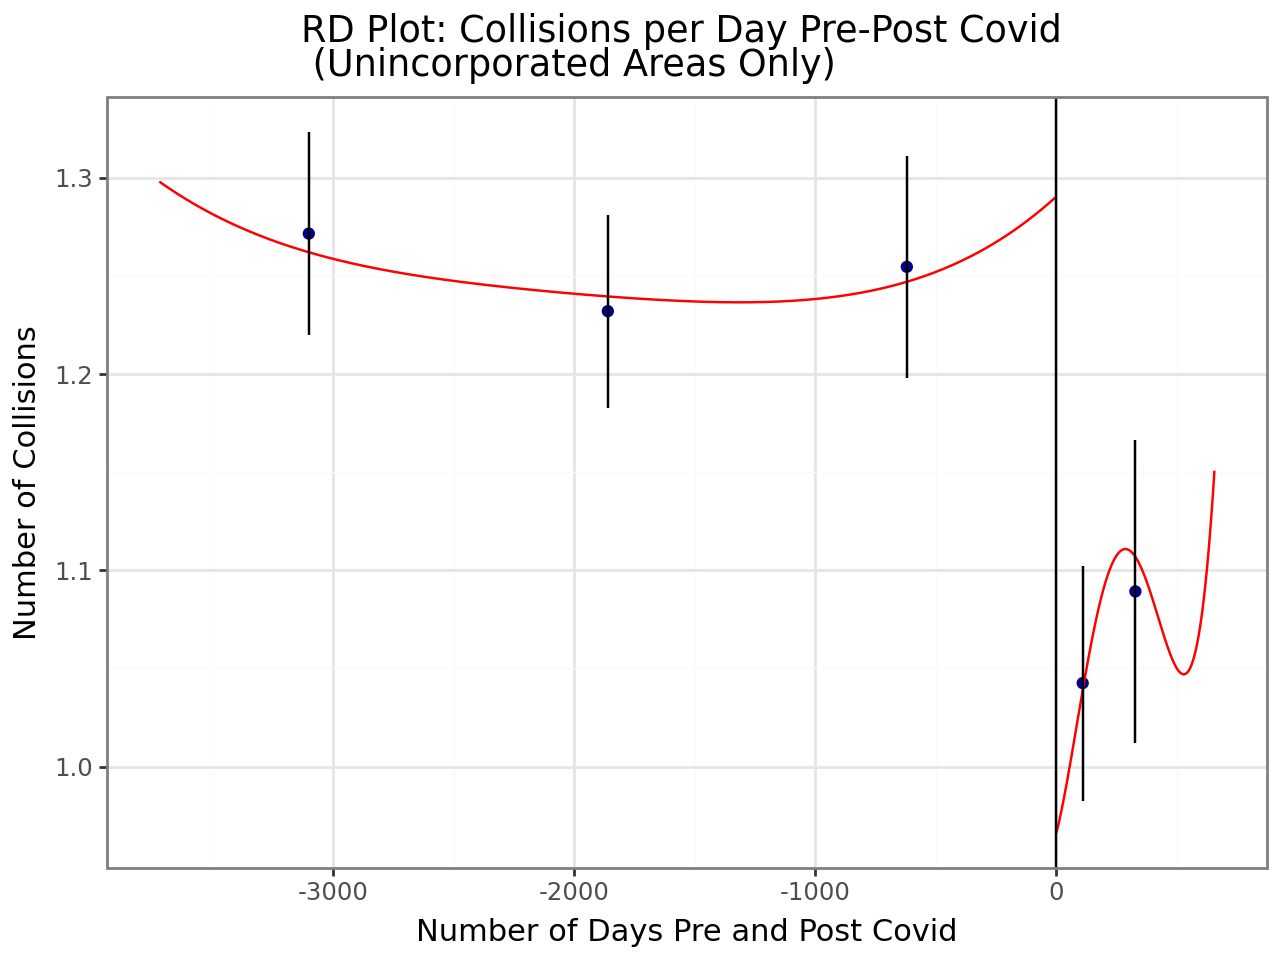

Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1194        103
Number of Unique Obs.           1194        103
Number of Effective Obs.          58         44
Bandwidth Estimation         194.898    194.898
Bandwidth Bias               328.217    328.217
rho (h/b)                      0.594      0.594

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.554    0.176    -3.14   1.691e-03     [-0.9, -0.208]
Bias-Corrected    -0.615    0.176   -3.484   4.937e-04   [-0.961, -0.269]
Robust            -0.615    0

In [62]:
### instead of testing effectiveness of vision zero, test effect of pandemic
covid_effects_ui = dfin_ui.groupby(["postcovid"])["dr_number"].count().reset_index(name='Collisions')

# y = number of collisions
# x = num of days pre-post Covid declaration

num_collisions_covid_ui = covid_effects_ui["Collisions"]
days_coll_covid_ui = covid_effects_ui.postcovid.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_collisions_covid_ui, x=days_coll_covid_ui, binselect="es", ci=95,
         title="RD Plot: Collisions per Day Pre-Post Covid \n (Unincorporated Areas Only)",
         y_label="Number of Collisions",
         x_label="Number of Days Pre and Post Covid")

### rdrobust with all estimates
print(rdrobust(y=num_collisions_covid_ui, x=days_coll_covid_ui, all=True))

The number of collisions pre-/post- Covid-19 declaration has a statistically significant difference *but* there is little practical significance. Collisions can only be a discrete number, and 1.3 collisions a day is not very different from 1 collision a day except when summed through time.

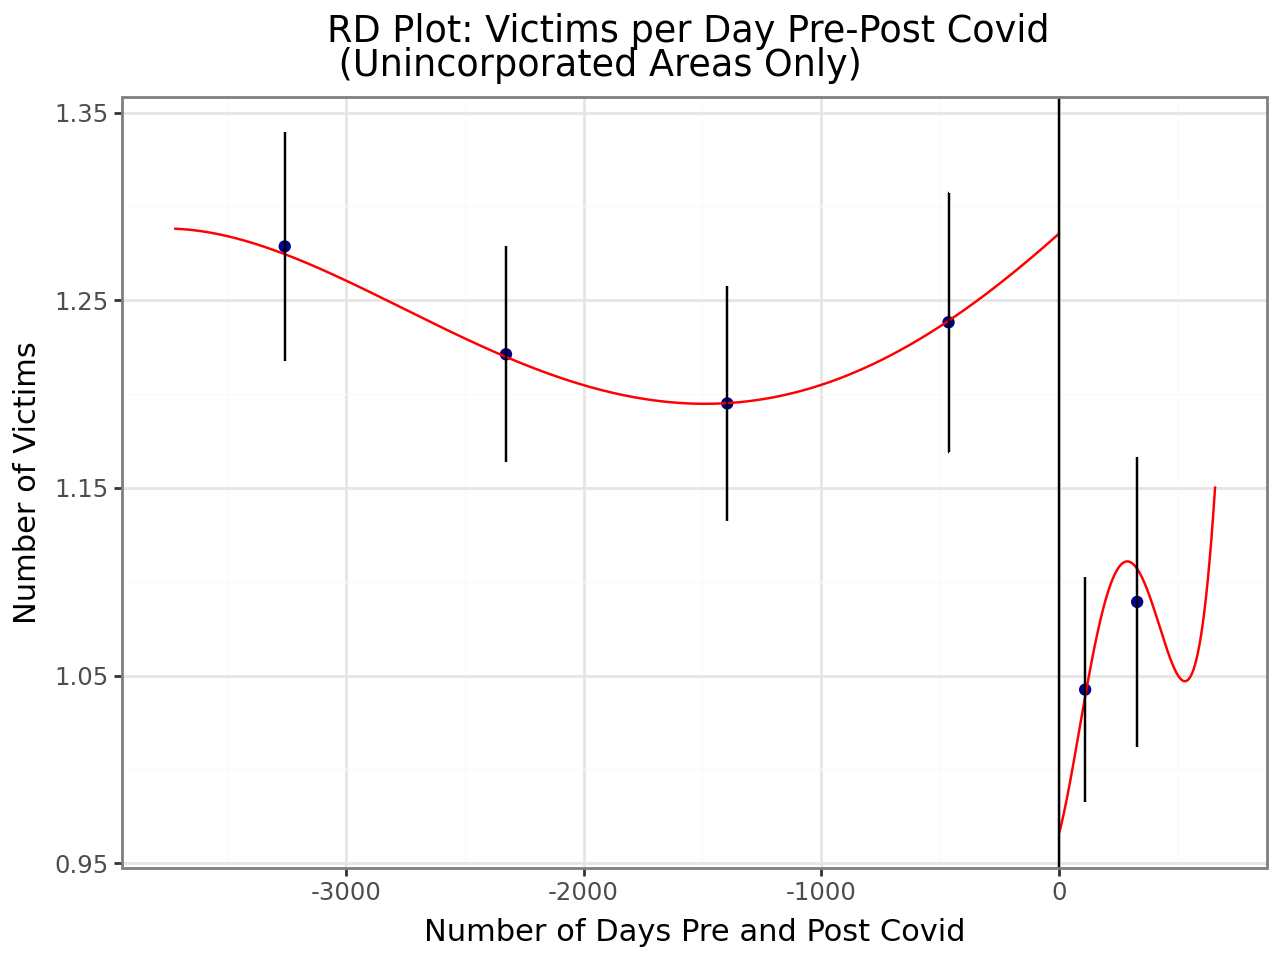

Call: rdrobust
Number of Observations:                  1297
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          1194        103
Number of Unique Obs.           1194        103
Number of Effective Obs.          58         44
Bandwidth Estimation         195.663    195.663
Bandwidth Bias               329.593    329.593
rho (h/b)                      0.594      0.594

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -0.553    0.176   -3.139   1.693e-03   [-0.898, -0.208]
Bias-Corrected    -0.614    0.176   -3.485   4.924e-04   [-0.959, -0.269]
Robust            -0.614    0

In [63]:
### isntead of testing effectiveness of vision zero, test effect of pandemic
covid_effects_victims_ui = pd.DataFrame(dfin_ui.groupby(["postcovid"])["victim"].sum()).reset_index()

# y = number of victims
# x = num of days pre-post Covid declaration

num_victims_covid_ui = covid_effects_victims_ui["victim"]
days_victims_covid_ui = covid_effects_victims_ui.postcovid.dt.days

# ### rdplot with 95% confidence intervals
rdplot(y=num_victims_covid_ui, x=days_victims_covid_ui, binselect="es", ci=95,
         title="RD Plot: Victims per Day Pre-Post Covid \n (Unincorporated Areas Only)",
         y_label="Number of Victims",
         x_label="Number of Days Pre and Post Covid")

### rdrobust with all estimates
print(rdrobust(y=num_victims_covid_ui, x=days_victims_covid_ui, all=True))

Likewise, the number of collisions with victims before and after Covid-19 was declared a pandemic is statistically significant, but practically speaking, the number of collisions is a discrete number, and they both round to about 1 collision a day.

#### Severe or Fatal Collisions Only

<ipython-input-64-cc4c1d6853b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<ipython-input-64-cc4c1d6853b9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


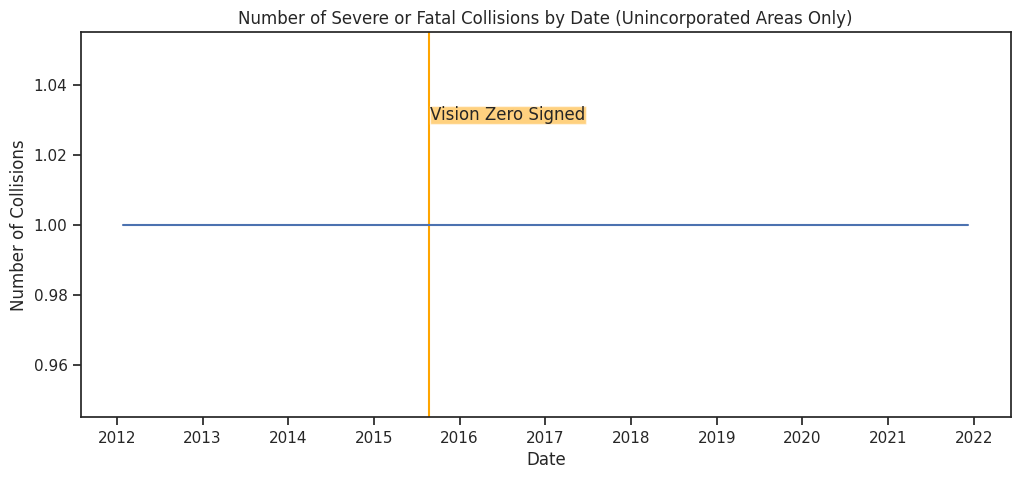

In [64]:
sev_fat_ui = injuries_ui[injuries_ui["mo_code_clean"].isin(["3024","3027"])]
sev_fat_ui.loc[:,'date_occurred_dt'] = sev_fat_ui['dttm_occurred'].dt.date
sev_fat_ui.loc[:,"pre_post_vision_zero"] = sev_fat_ui["dttm_occurred"].dt.date-datetime.date(2015,8,24)

sev_fat_collisions_ui = pd.DataFrame(sev_fat_ui.groupby(['date_occurred_dt']).dr_number.nunique()).rename(columns={"dr_number":"NumCollisions"}).sort_index()

sev_fat_col_fig_ui = plt.figure(figsize=(12,5))

plt.axvline(pd.to_datetime("2015-08-24"), color="orange")
plt.annotate("Vision Zero Signed", (pd.to_datetime("2015-08-30"),1.03),
             bbox=dict(boxstyle="square", fc="orange", alpha=0.5, pad=0))

plt.plot(sev_fat_collisions_ui)
plt.xlabel("Date")
plt.ylabel("Number of Collisions")
plt.title('Number of Severe or Fatal Collisions by Date (Unincorporated Areas Only)')
plt.show()

In [65]:
print(min(sev_fat_collisions_ui.NumCollisions))
print(max(sev_fat_collisions_ui.NumCollisions))

1
1


Since there's a flat line of 1 collision per day with a severe or fatal injury, then there is no point in running a regression discontinuity analysis. There's no change in slope, and therefore there's no difference before/after Vision Zero, and with no change in due to the pandemic declaration.

In [66]:
severe_fat_ui_dr_numbers = sev_fat_ui.dr_number
df_ui_severe_fatal = dfin_ui.merge(severe_fat_ui_dr_numbers, on='dr_number', how='inner')

lat_ui_sev_fat = df_ui_severe_fatal["latitude"][np.logical_not(np.isnan(df_ui_severe_fatal["latitude"]))]
lon_ui_sev_fat = df_ui_severe_fatal["longitude"][np.logical_not(np.isnan(df_ui_severe_fatal["longitude"]))]

map_ui_severe_fatal = folium.Map(location=[df_ui_severe_fatal["latitude"].mean(),df_ui_severe_fatal["longitude"].mean()],
                 zoom_start=10,
                 control_scale=True)
HeatMap(list(zip(lat_ui_sev_fat, lon_ui_sev_fat))).add_to(map_ui_severe_fatal)

map_ui_severe_fatal

This is the map of where the collisions that have records of severe or fatal injuries in unincorporated areas. There are much fewer collisions in total.

# Conclusion

**The first few paragraphs are the same as the from LA_Traffic_Collisions_2_Analysis_FullDataset.ipynb**

While LA has a lot of collisions in general, the number of severe or fatal injuries from collisions, in comparison, is "rare." There are about 139 collisions a day (prior to Covid) and of them, only 4 of them are severe/fatal collisions on average. This means that only about 2% of a LA collisions in a day would  contain severe or fatal injuries. However, this number can add up. Under the assumption that there's only one person with severe or fatal injuries when the relevant MO codes appear on the collision report, that means there will be at least 1,358 people affected per year, and this number is projected to increase as shown by the analysis of this data.

Not only that, but the number of collisions have only increased by the year  and the proportion of severe and fatal injuries have not changed much. There is actually a statistically significant increase in the overall number of collisions and victims post-Vision Zero enactment.

If we look at the same data, there is a drop in the number of collisions and victims when Covid-19 was declared a pandemic by the WHO. There was already the start of a trend for the decrease prior to the pandemic declaration, and this may be explained by people hearing news of the pandemic, and starting to decrease their outdoor activities. Once the pandemic was officially declared, there was a sharp decline in the number of collisions. When we take a look at the number of severe or fatal injuries, there were still about 3-5 collisions. Even if Covid-19 lowered the total amount of collisions, the number of severe or fatal injuries remained about the same.

This implies that Vision Zero isn't effective at decreasing the number of collisions or the number of severe or fatal wounds. Removing the number of cars on the streets may be effective at decreasing the number of collisions overall, but not the number of severe or fatal injuries from collisions. And if the trends continue, then there will be more and more collisions in the coming years.


---


**The following paragraph was added after the analysis of the unincorporated areas**

However, the story changes when we are only taking a look at the unincorporated areas. Practically speaking, it doesn't seem like Vision Zero is effective because there are very few collisions that have severe or fatal injuries in the unincorporated areas. There is no statistical difference in the number of collisions with or without victims due to Vision Zero being signed. There may be a reduction when there are less cars in the road (as a byproduct of the pandemic declaration), but the average drops from about 1.3 to 1, and the number of collisions is a discrete number. If Vision Zero is effective, it's not being implemented in the areas of LA where there are the most collisions and where the severe or fatal collisions are occurring. LA may need to re-evaluate which programs and how it needs to improve traffic safety.